# Creating your project and building the hydrological model

## Introduction

Notebook for the workflow **Snakefile_historical_hydrology**: 
1.  creates a wflow model based on global data for the selected region, 
2.  runs the model for a selection of forcing datasets for the historical period, 
3.  evaluates the model performance using observed streamflow data (if provided) and snow cover extent (if provided).

In [1]:
# Import some python libraries we will need to run this notebook
import os
import pandas as pd
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Defining your project region and properties

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\repos\blueearth_cst'
os.chdir(cst_path)

To create your model for any given (sub)basin, you will need to provide:

- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (e.g., myregion.shp)

For more details on the exact syntax, please have a look at:
https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point coordinates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [4]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, please check the hydromt documentation: 
# https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [12.3758, 46.4076], 'uparea': 70}"

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

# Info on the historical climate data is used in the historic model run + reference data for the weather generator
# Time horizon of the historical period
starttime: "2000-01-01T00:00:00"
endtime: "2010-12-31T00:00:00"

# Historical gridded climate data sources (name as available in the data_sources catalog file). 
clim_historical: 
  - era5
  - chirps_global

#colors to use for plotting (same order as provided in clim_historical)
clim_historical_colors:
  - blue
  - green

###########################################################################################
#################################### Model building #######################################

# Grid resolution of the model in degrees
model_resolution: 0.0166666
# Path to model build configuration settings
model_build_config: "tests/wflow_build_model.yml"
waterbodies_config: "tests/wflow_update_waterbodies.yml"

# Options to prepare wflow forcing for the different dataset in clim_historical
forcing_options:
  era5: # clim/precip source name
    temp_pet_fn: era5 # data source for temperature and pet if computed
    pet_fn: # direct data source for pet else will be computed using the temp data source
    dem_forcing_fn: era5_orography # data source for orography for downscaling temperature
    pet_method: debruin # method to compute pet
    press_correction: true
  chirps_global:
    temp_pet_fn: era5
    dem_forcing_fn: era5_orography
    pet_method: debruin
    press_correction: true

# If available, please put here the path to the available observation stations locations file
# csv file containing four columns: station_ID, name, x, y
output_locations: "tests/data/observations/discharge-locations-grdc.csv" # If set to None, will default to the wflow outlets
# Path to the file with observed discharge timeseries per station 
observations_timeseries: "tests/data/observations/observations-discharge-grdc.csv" 
# Path or data catalog entry to gridded snow cover [%]
observations_snow: modis_snow

# List of wflow output variables to save
# Supported variables: ['river discharge', 'precipitation', 'overland flow', 'actual evapotranspiration', 'groundwater recharge', 'snow', 'glacier']
# Comment out to disable saving
# Scalar csv
wflow_outvars: ['river discharge', 'precipitation', 'overland flow', 'actual evapotranspiration', 'groundwater recharge', 'snow', 'glacier']
# Gridded netcdf
wflow_outvars_gridded: ['snow']

# Plotting options for historical hydrology
historical_hydrology_plots:
  plot_budyko: true # Additional plot of budyko
  basin_map:
    output_locations_legend: "output locations"
    legend_loc: "lower right"
  flow:
    max_nan_per_year: 60 #maximum number of days per year with missing values for year to be considered in the analysis
    max_nan_per_month: 5 #maximum number of days per month with missing values for month to be considered in the analysis
  clim:
    skip_temp_pet_sources: # list of climate sources for which temp, pet will not be plotted (e.g. chirps is only available for precipitation and is combined with era5 temperature)
      - chirps_global

Writing ./config/my-project-settings.yml


To evaluate the model performance using observed data, the user may provide timeseries and locations of observed streamflow. 
The output locations is a csv file, provided in *output_locations* of the config file. The csv file should contain 4 columns with headers: 
- station_ID 
- name
- x
- y

An example is shown below:

In [5]:
pd.read_csv("tests/data/observations/discharge-locations-grdc.csv")

wflow_id       station_name        x        y
0   6349400  PONTE DELLA IASTA  12.5178  46.5318

The timeseries containing the actual data is also provided in a csv file (*observations_timeseries*). 

The format should include a column with the time dimension and columns with discharge timeseries (m3/s) for each *wflow_id* of the station locations (with a `;` delimiter). This is shown below:   

In [6]:
pd.read_csv("tests/data/observations/observations-discharge-grdc.csv", parse_dates=True, index_col=0, header=0, sep=";")

6349400
time               
2000-01-01     5.76
2000-01-02     5.80
2000-01-03     5.80
2000-01-04     5.70
2000-01-05     5.80
...             ...
2008-12-27     6.57
2008-12-28     6.60
2008-12-29     6.40
2008-12-30     6.20
2008-12-31     6.03

[3288 rows x 1 columns]

In addition, the workflow allows to compare modeled snow cover extent with satellite observations from MODIS. Gridded MODIS data should then be provided as a data catalog entry in the config file (*observations_snow: modis_snow*). 

## Running the historical hydrology workflow

The first line is to create an image of our workflow with snakemake to verify that all our settings are well taken into account.

In [7]:
! snakemake -s snakemake/Snakefile_historical_hydrology.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_hydrology.png

Building DAG of jobs...


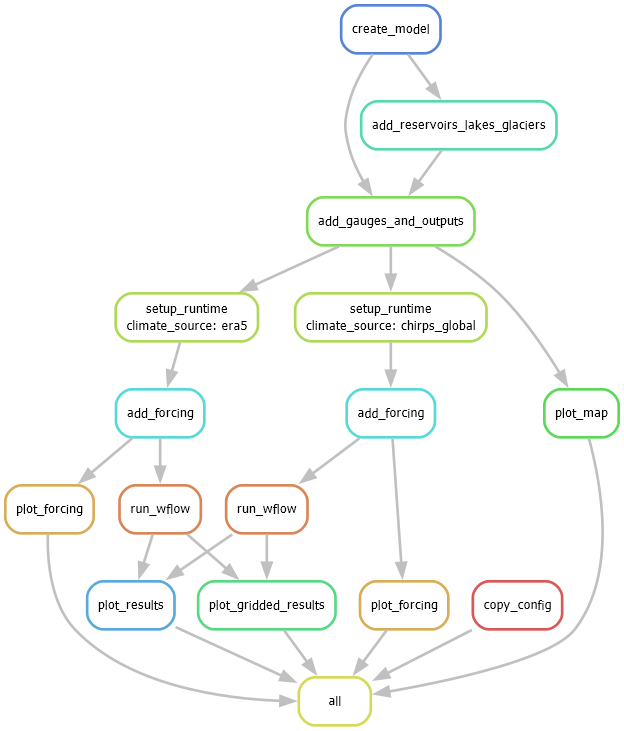

In [8]:
display.Image("./dag_historical_hydrology.png")

Let's have a closer look at this diagram, which shows the subsequent rules of the snakemake workflow:

1. `create model`: the model is created for the region of interest (specified in *model_region* of the config file) at the chosen resolution (*model_resolution* in the config file). To build the model, the settings are described in *model_build_config*.   
2. `add_reservoirs_lakes_glaciers`: Reservoirs, lakes and glaciers (if any) are added to the model in a subsequent step, based on the settings described in *waterbodies_config*.
3. `add_gauges_and_outputs`: Gauges at the locations of (any available) observation stations are added to the model. These locations are used to directly save simulated discharge as scalar timeseries in a csv file. The location of the observation stations are provided in *output_locations* of the config file. The required outputs (state and flux variables) from the model that need to be saved from the simulation are also added to the model (*wflow_outvars* and *wflow_outvars_gridded*).
4. `setup_runtime`: the config file to prepare the forcing for the list of climate sources (*clim_historical*) and for the given historical period (*starttime*, *endtime*) are prepared. 
5. `add_forcing`: in this step, the gridded forcing file, including precipitation, potential evaporation and for each climate sources are written to netcdf file, which will be used to run the wflow model. 
6. `run_wflow`: the wflow model is then run with each climate source forcing file as input and all required output state and flux variables are saved.
7. `plot_map`: saves a map of the basin, elevation, gauges locations, reservoirs, lakes and glaciers.
8. `plot_forcing`: saves gridded maps of mean annual precipitation, temperature, potential evaporation for each of the climate sources. 
9. `plot_results`: saves a collection of figures to analyze the model performance. These figures are described in more detail in this notebook. 


Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

In [9]:
! snakemake --unlock -s snakemake/Snakefile_historical_hydrology.smk --configfile config/my-project-settings.yml

Building DAG of jobs...
Unlocked working directory.


Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [ ]:
! snakemake all -c 1 -s snakemake/Snakefile_historical_hydrology.smk --configfile config/my-project-settings.yml --dryrun

In the following, we will actually run the snakemake workflow for the historical hydrology:

In [11]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_historical_hydrology.smk --configfile config/my-project-settings.yml

c:\Users\boisgont\AppData\Local\miniforge3\envs\cst\Lib\subprocess.py:1016: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


Assuming unrestricted shared filesystem usage.
host: L03519
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                              count
-----------------------------  -------
add_forcing                          2
add_gauges_and_outputs               1
add_reservoirs_lakes_glaciers        1
all                                  1
copy_config                          1
create_model                         1
plot_forcing                         2
plot_gridded_results                 1
plot_map                             1
plot_results                         1
run_wflow                            2
setup_runtime                        2
total                               16

Select jobs to execute...
Execute 1 jobs...

[Wed Oct  2 10:01:42 2024]
localrule copy_config:
    input: tests/wflow_build_model.yml, config/my-project-settings.yml, tests/wflow_update_waterbodies.yml
    output: ex

## Results

First check that snake did run everything.

The diagram will show dotted lines when a rule has already been performed. 

In [12]:
! snakemake -s snakemake/Snakefile_historical_hydrology.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_historical_hydrology.png

Building DAG of jobs...


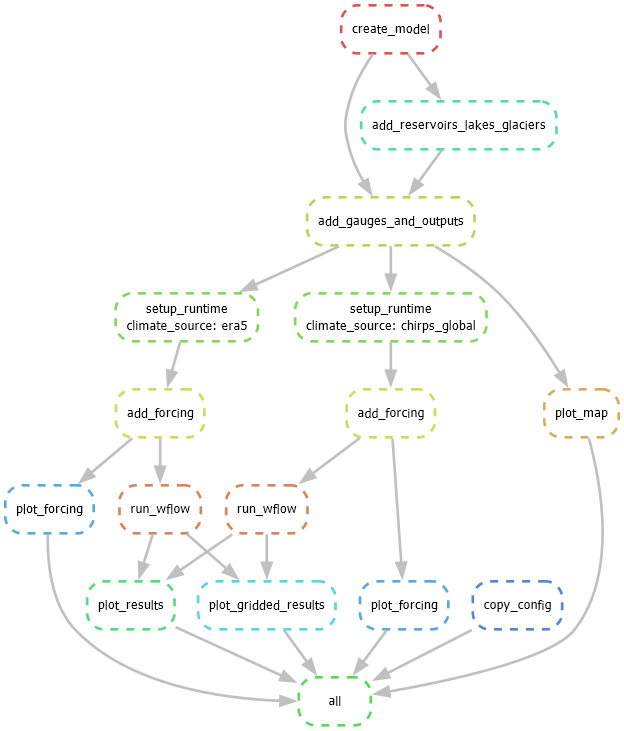

In [13]:
display.Image("./dag_historical_hydrology.png")

Let's see which files where created in our output folder. The location of the output folder is defined in the config file under *project_dir*. The results from the historical hydrology run are saved in hydrology_model. The plots made are saved under `examples/myModel/plots/wflow_model_performance`

In [14]:
root = "examples/myModel/hydrology_model"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel/hydrology_model
 - hydromt.log
 - hydromt_data.yml
 - reservoir_accuracy.csv
 - reservoir_timeseries_jrc.csv
 - staticmaps.nc
 - wflow_sbm.toml
examples/myModel/hydrology_model\instate
examples/myModel/hydrology_model\run_default
 - hydromt.log
 - log.txt
 - output_chirps_global.csv
 - output_chirps_global.nc
 - output_era5.csv
 - output_era5.nc
 - wflow_sbm_chirps_global.toml
 - wflow_sbm_era5.toml
examples/myModel/hydrology_model\run_default\instate
examples/myModel/hydrology_model\run_default\outstate
 - outstates_chirps_global.nc
 - outstates_era5.nc
examples/myModel/hydrology_model\run_default\run_default
examples/myModel/hydrology_model\run_default\staticgeoms
examples/myModel/hydrology_model\staticgeoms
 - basins.geojson
 - basins_highres.geojson
 - gauges.geojson
 - gauges_discharge-locations-grdc.geojson
 - glaciers.geojson
 - region.geojson
 - reservoirs.geojson
 - reservoirs_lakes_glaciers.txt
 - rivers.geojson
 - subcatch_discharge-locations-grdc.geojson


The model we have set up in this example notebook is for the Piave, a small basin in Italy. The GRDC dataset includes one station at PONTE DELLA IASTA. The elevation of the basin, the glaciers, reservoirs and lakes are shown in the figure below. 

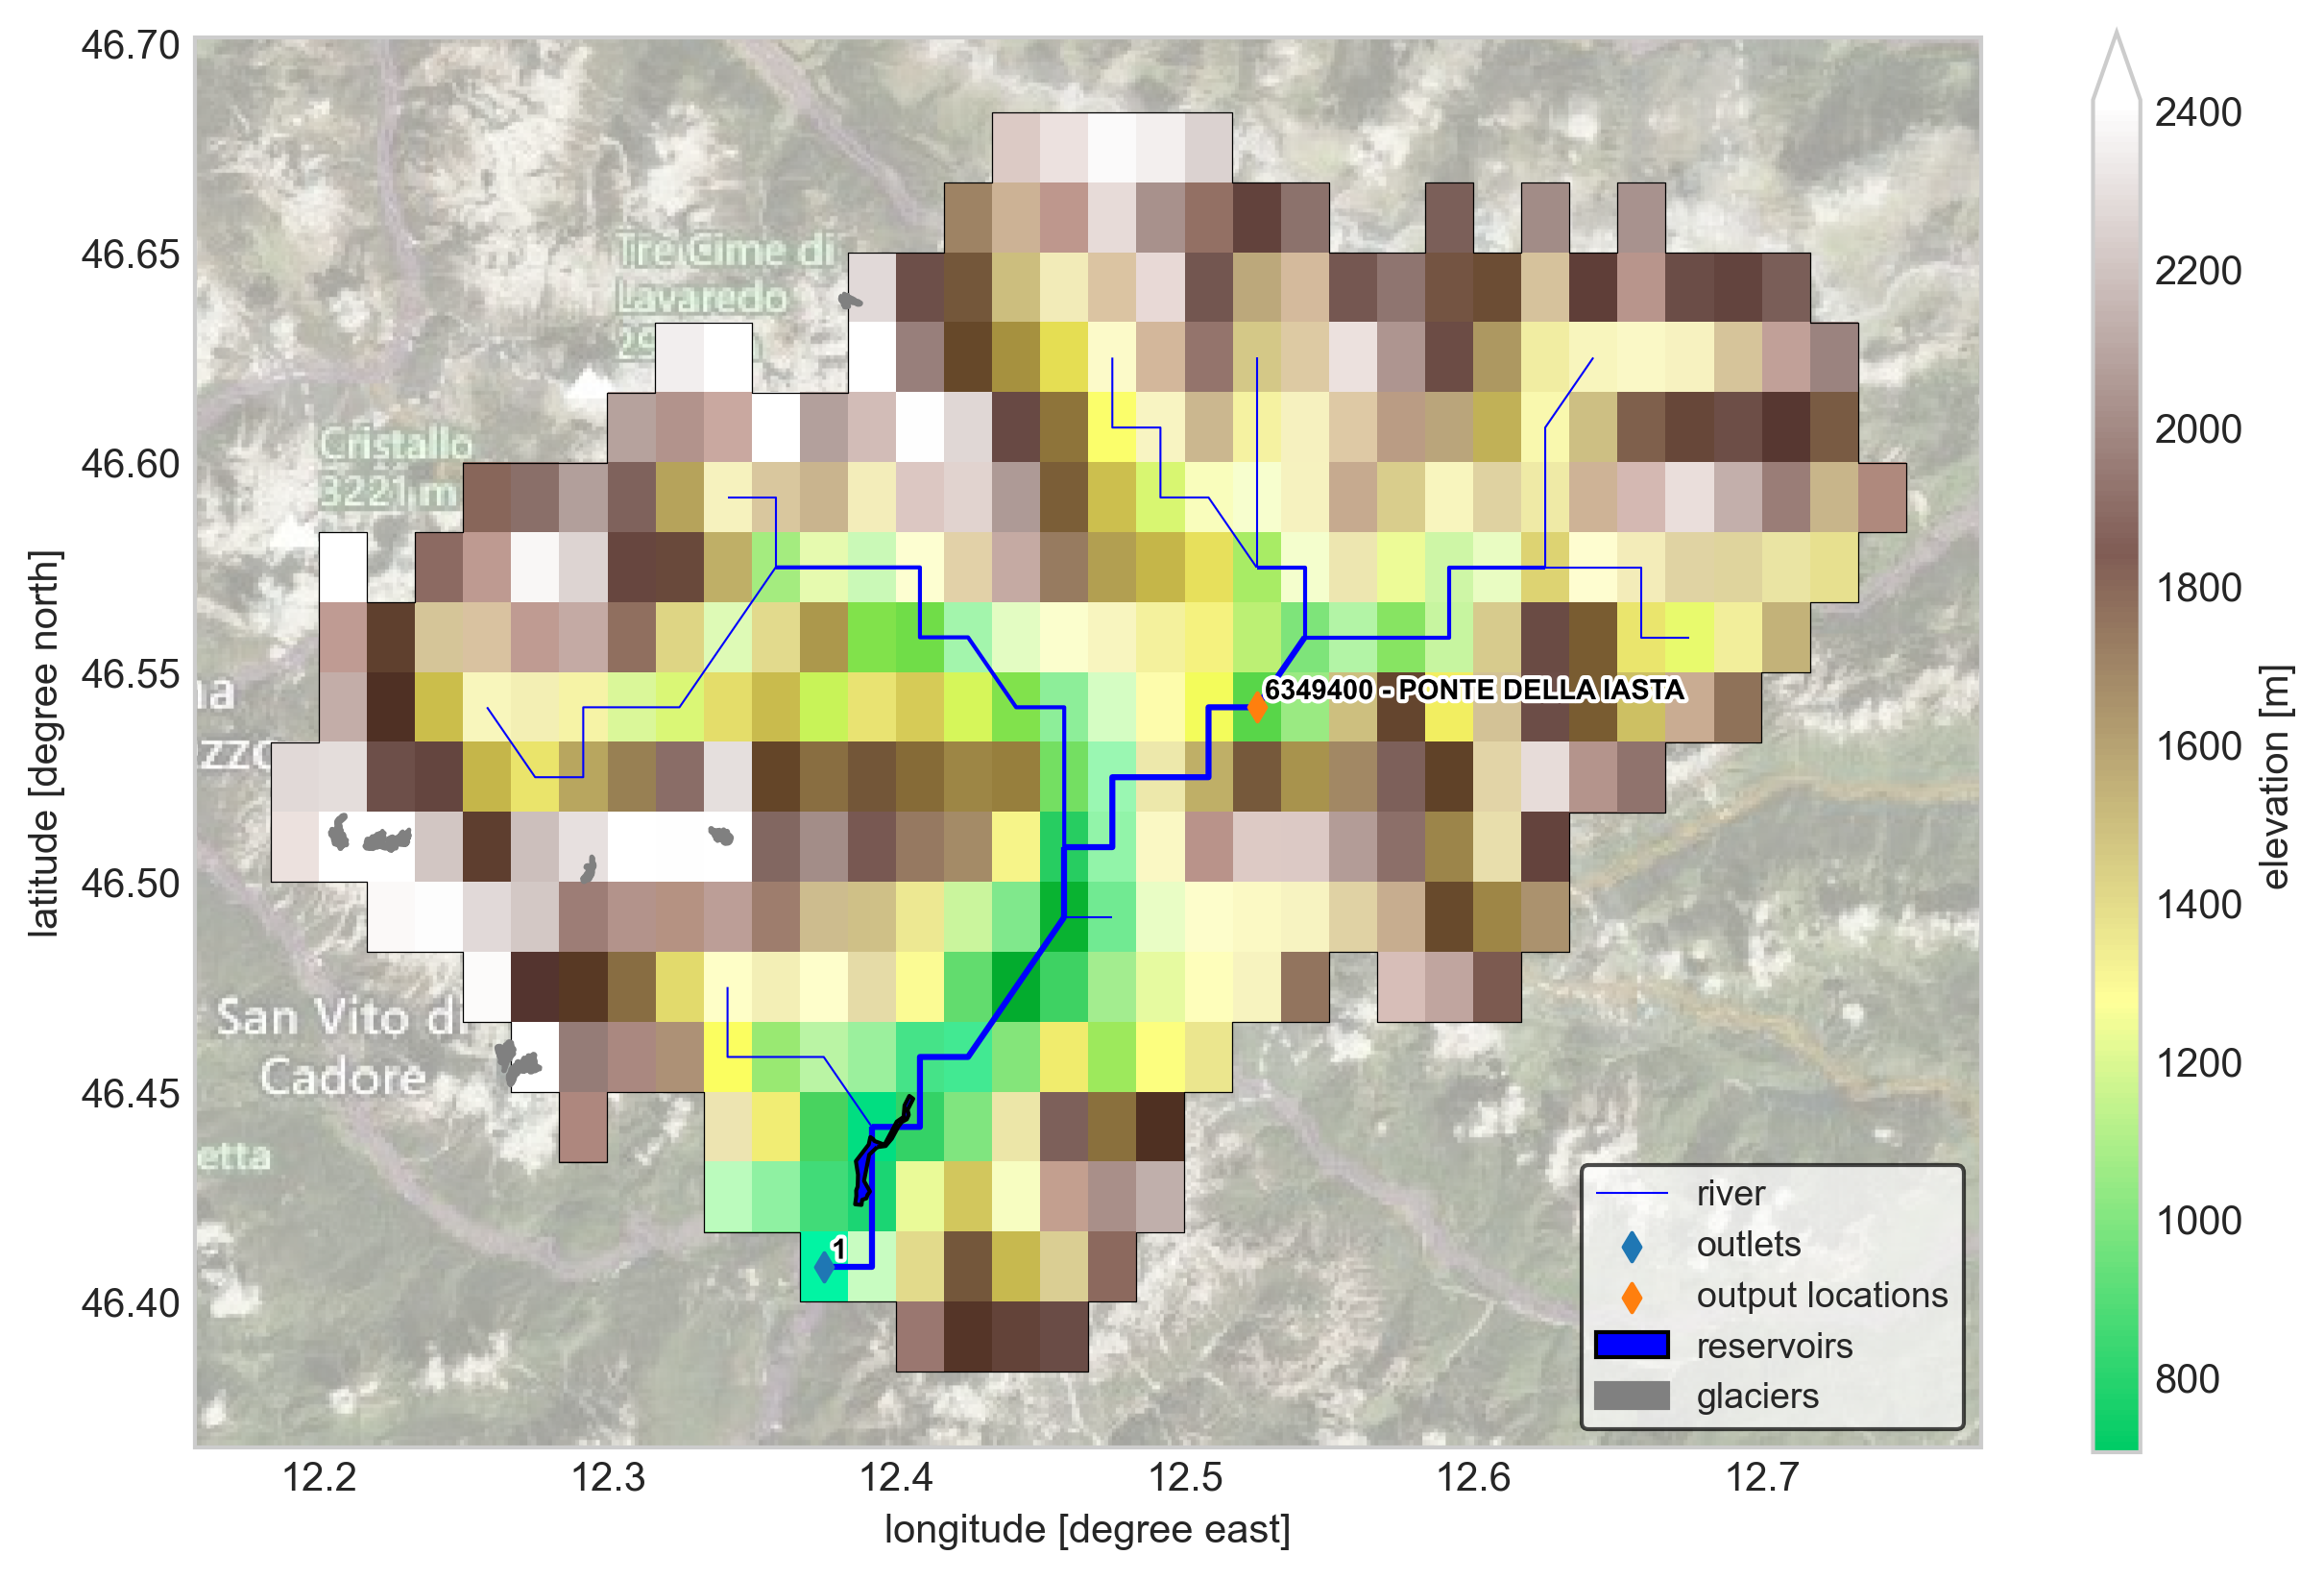

In [15]:
display.Image("./examples/myModel/plots/wflow_model_performance/basin_area.png")

The model is evaluated by comparing observed and simulated discharges at the annual, monthy and daily timescale. In addition, the model performance is compared for the several climate sources used as forcing into the model, as shown in the figure below.

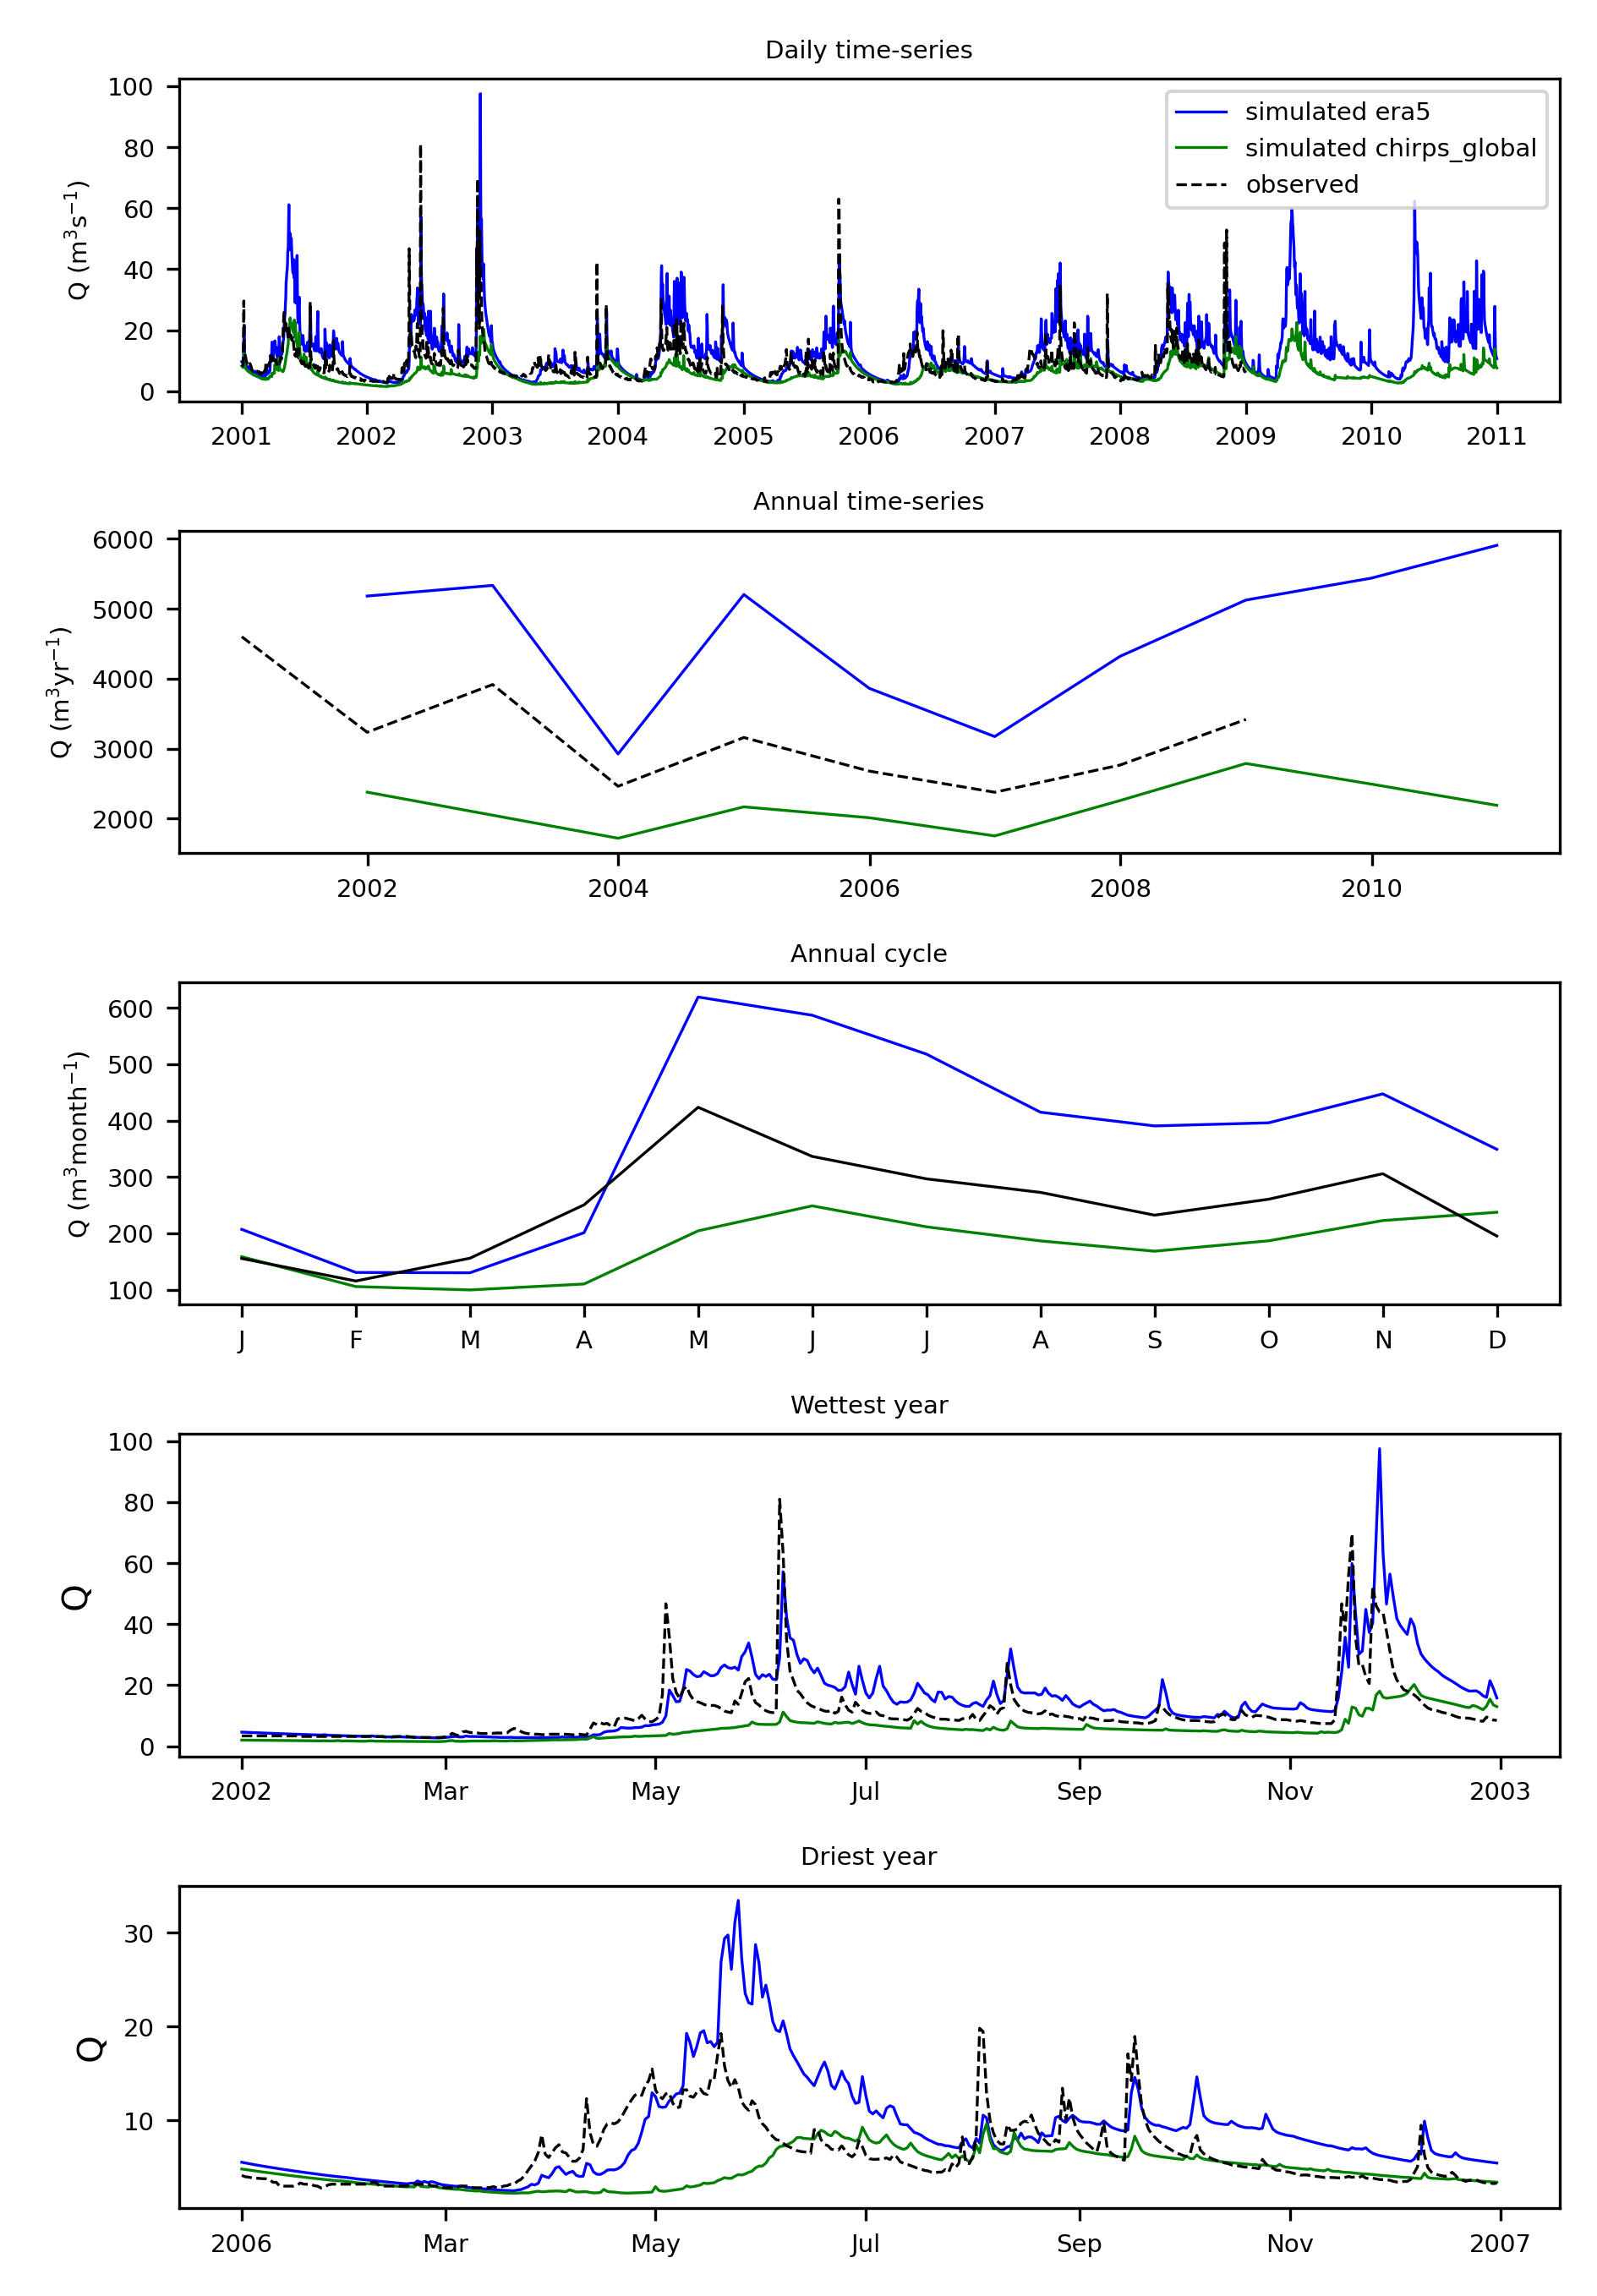

In [16]:
display.Image("./examples/myModel/plots/wflow_model_performance/hydro_PONTE DELLA IASTA.png")

The figure illustrates that streamflow is overestimated when using the ERA5 dataset as input, while it is underestimated when CHIRPS_global dataset is used as input. Although the model is uncalibrated, the same model parameters are used for both forcing, suggesting that the observed differences are due to the forcing. 

Besides the hydrograph, we also plot several other hydrological signatures including:
- flow duration curves of the flows and log of the flows, 
- cumulative streamflow,
- annual maximum streamflow,
- annual minimum mean 7 days streamflow, 
- KGE, NSE, NSE log Q.

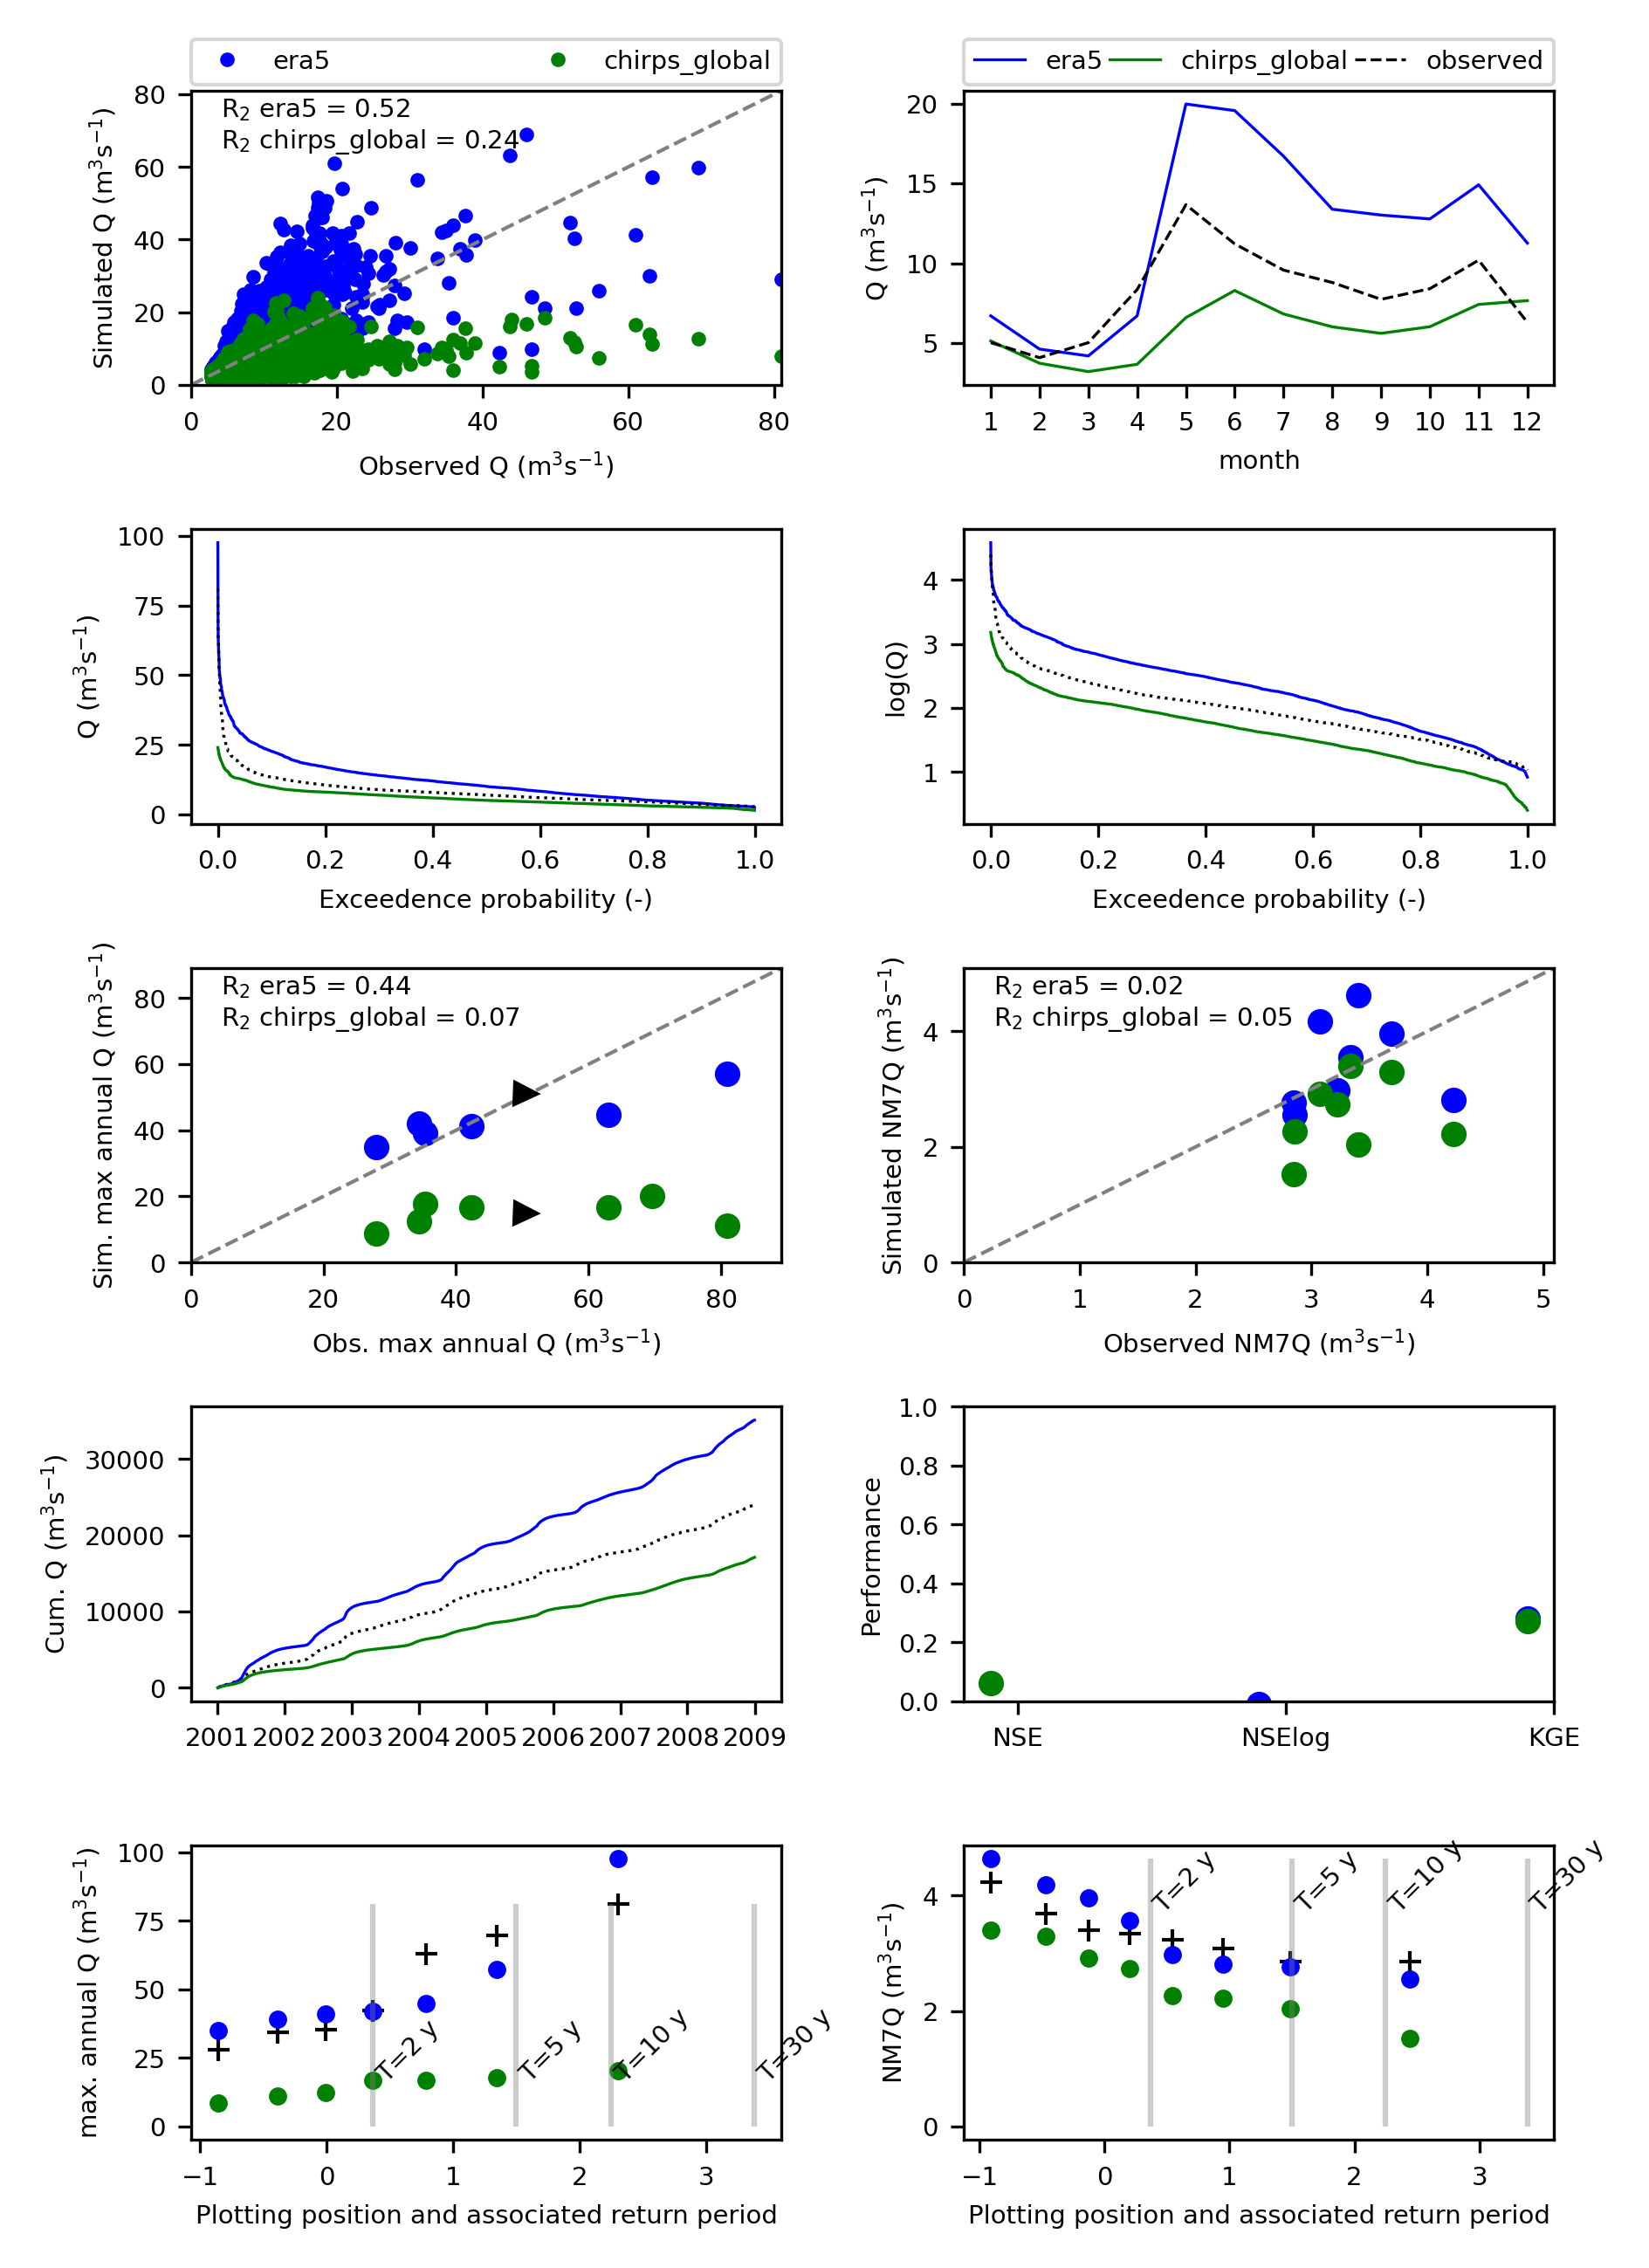

In [17]:
display.Image("./examples/myModel/plots/wflow_model_performance/signatures_PONTE DELLA IASTA.png")

Besides streamflow, results are also available for internal state and flux variables, including:
- actual evaporation,
- groundwater recharge,
- overland flow, 
- snow storage, 
- glacier storage

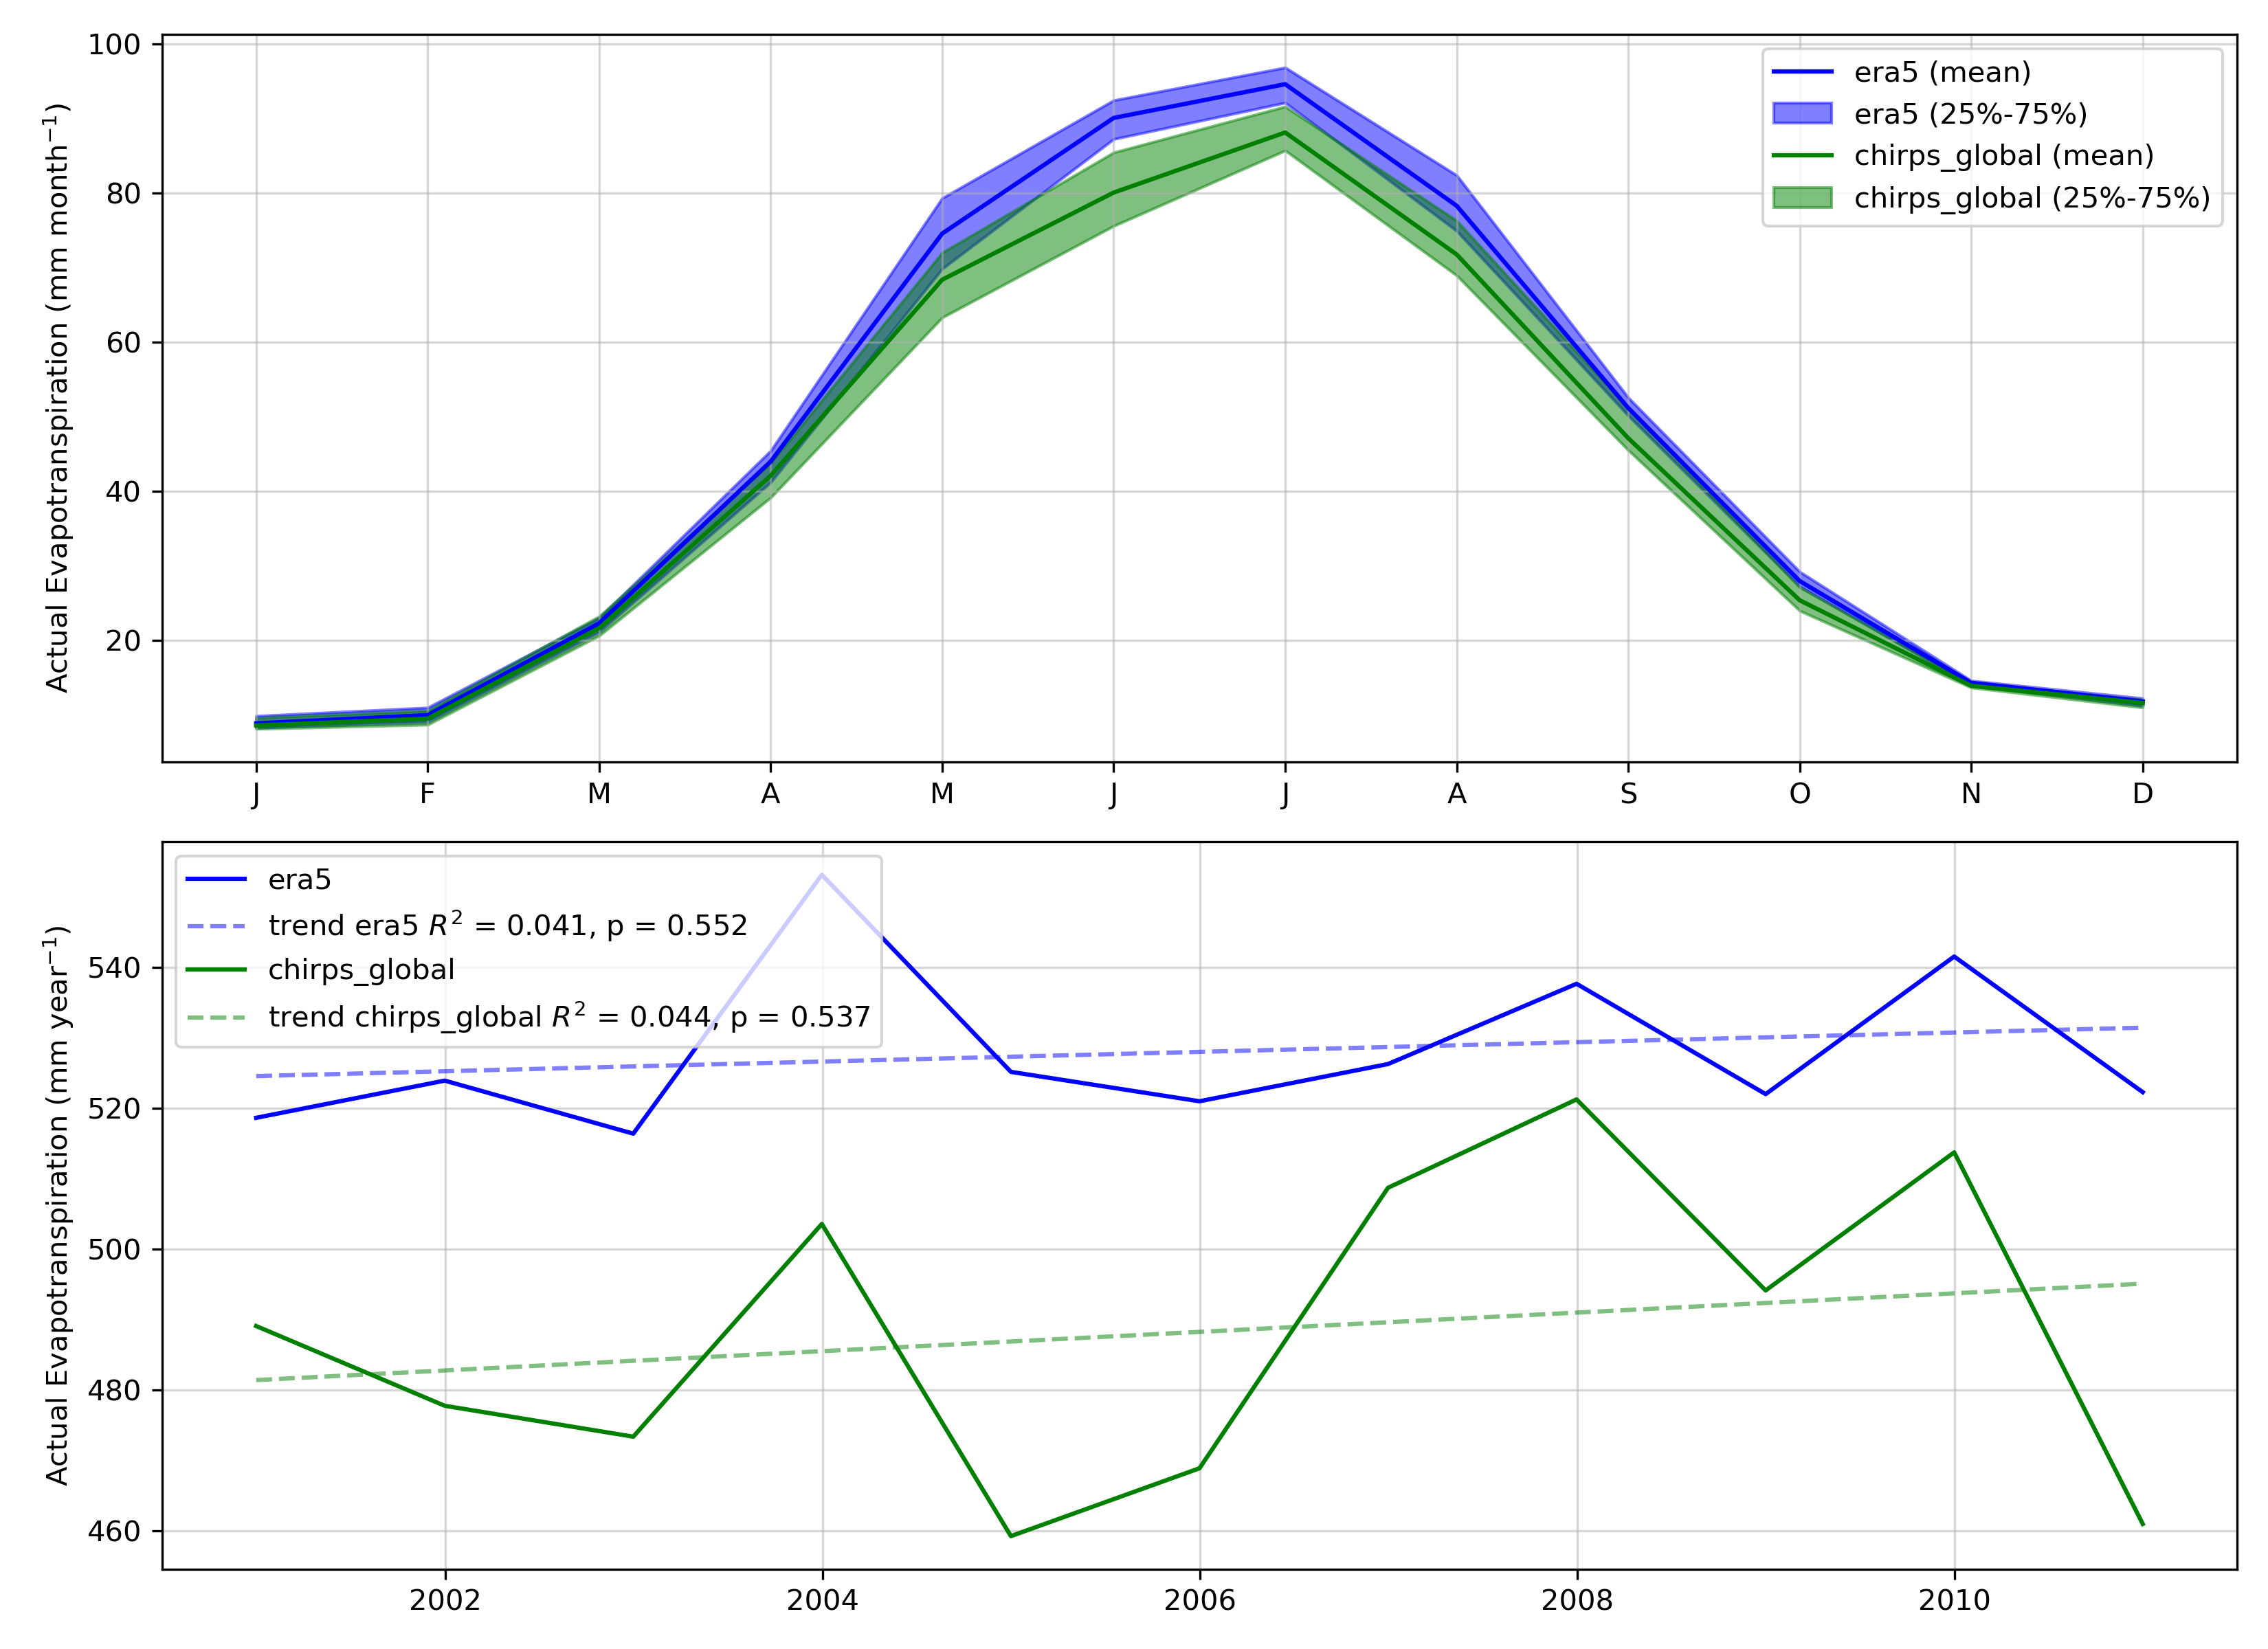

In [18]:
display.Image("./examples/myModel/plots/wflow_model_performance/actual evapotranspiration_basavg.png")

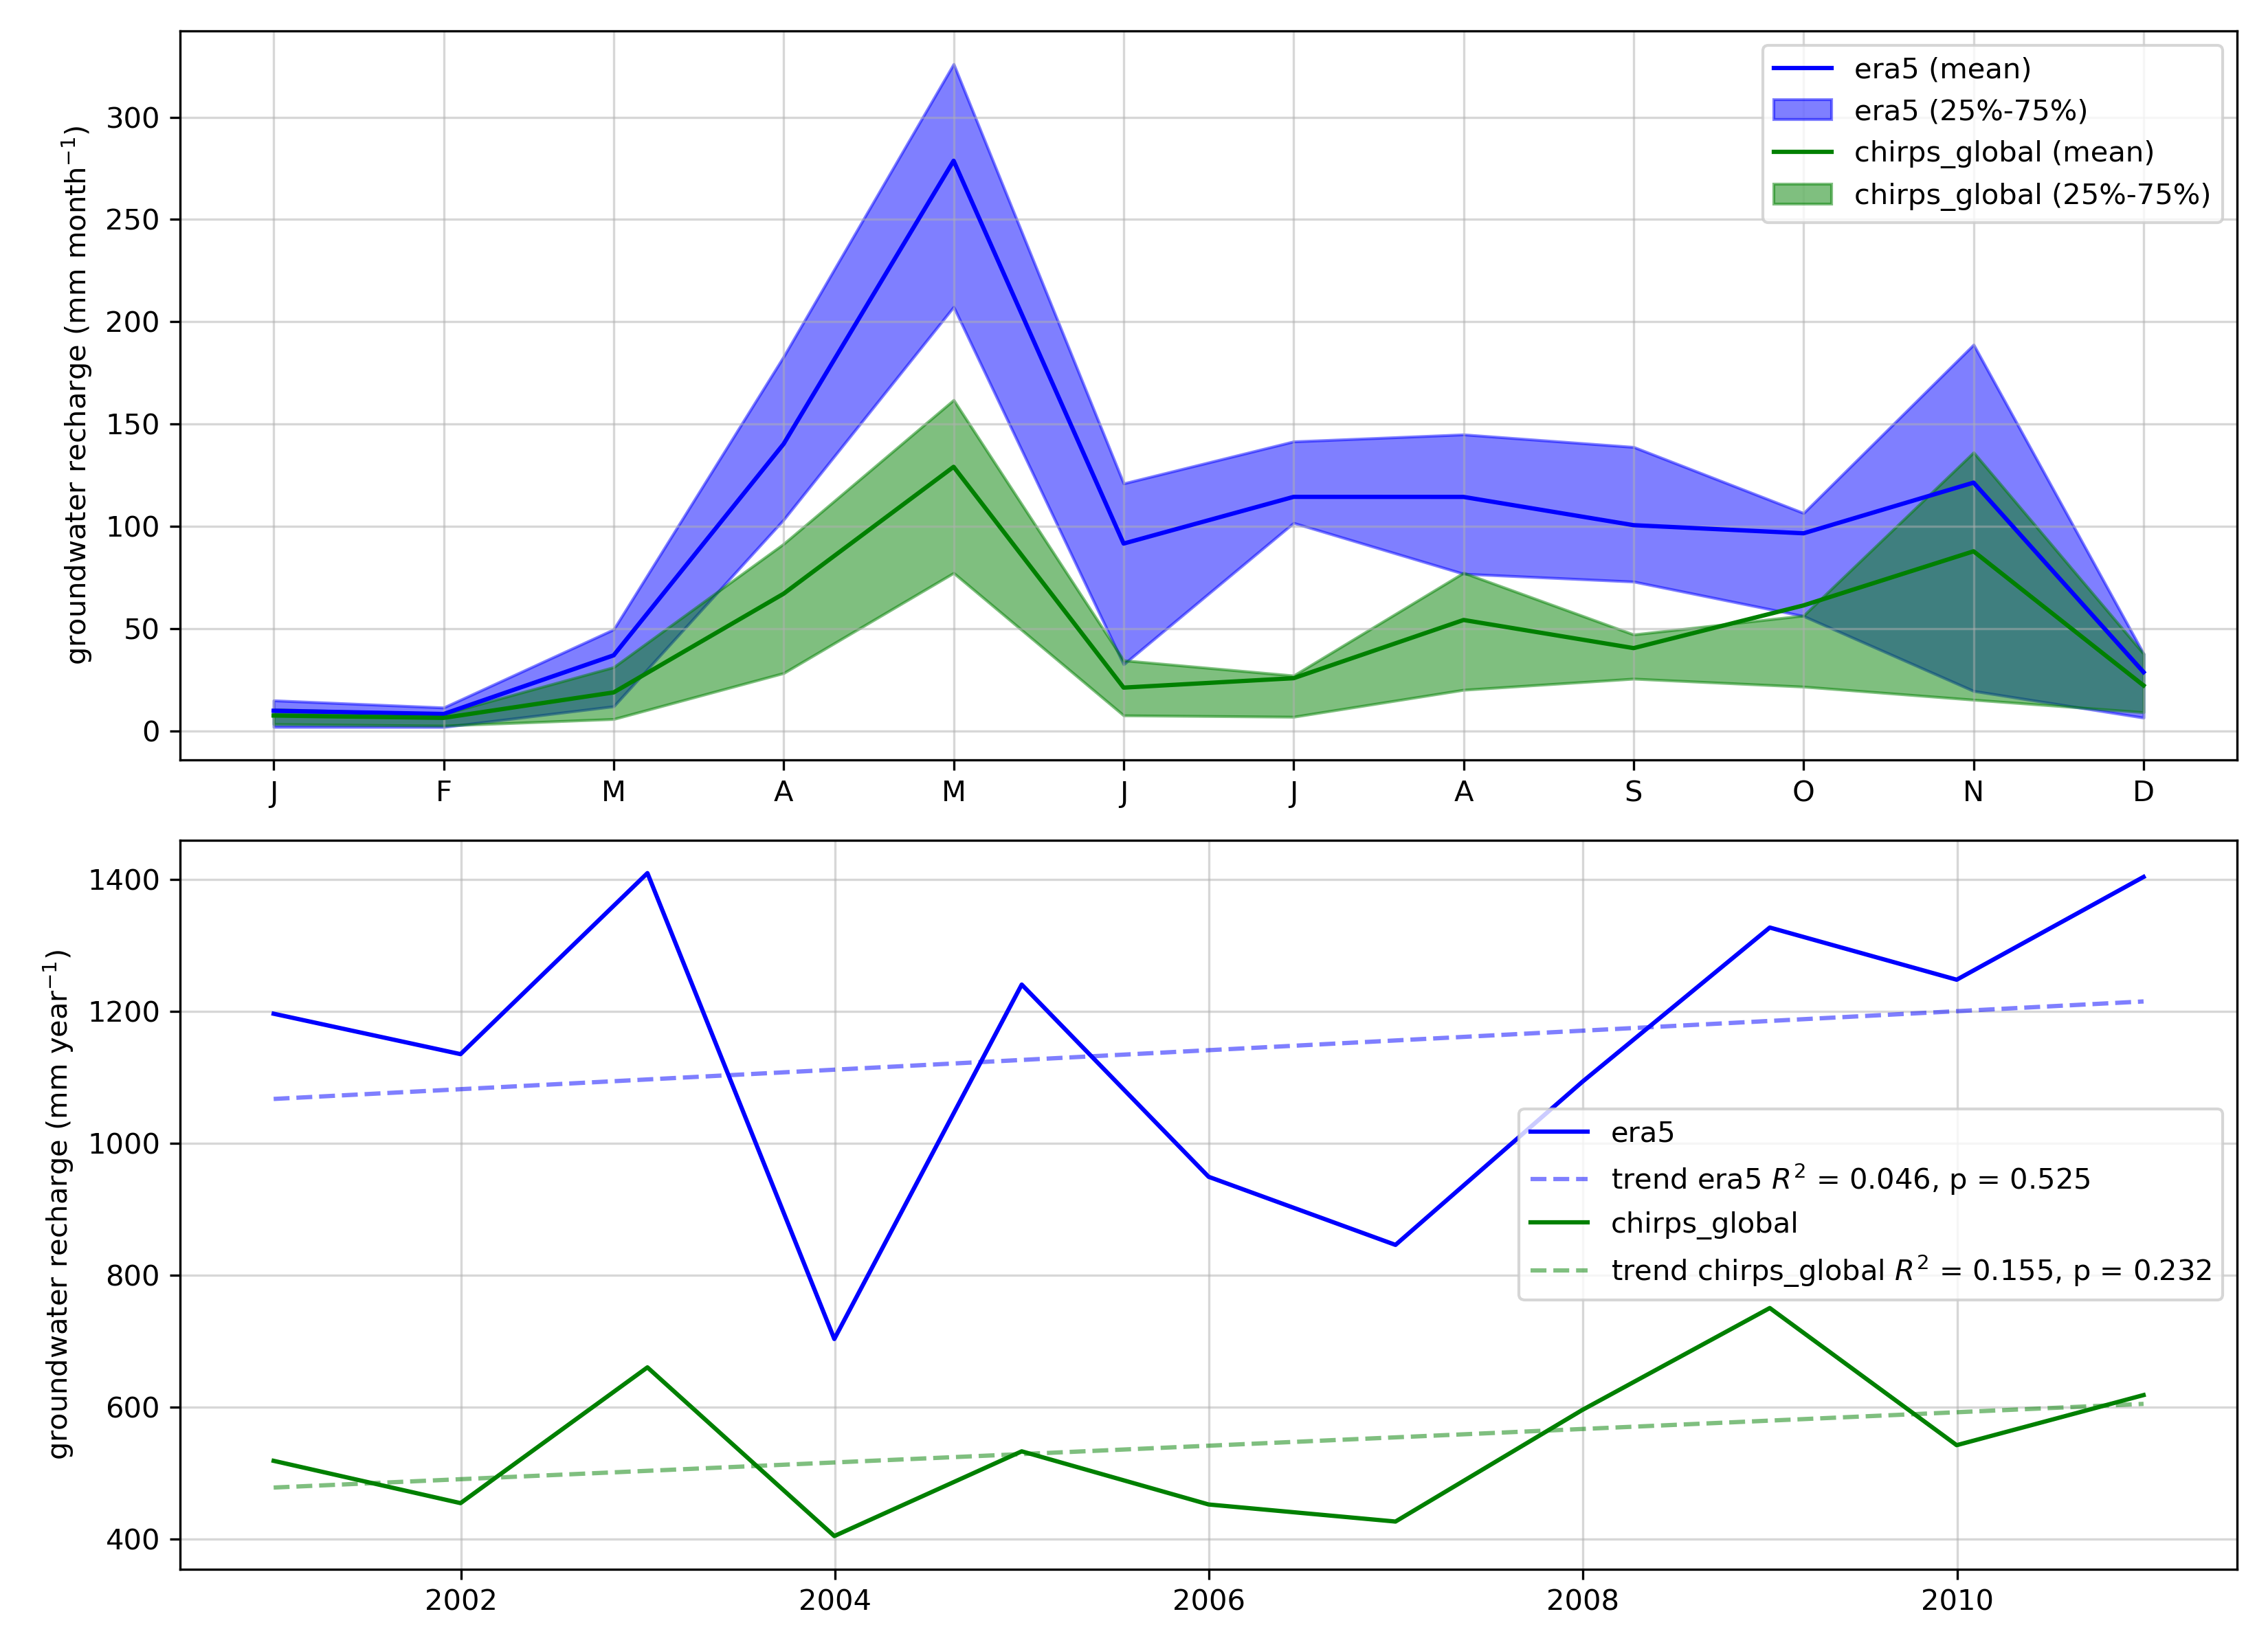

In [19]:
display.Image("./examples/myModel/plots/wflow_model_performance/groundwater recharge_basavg.png")

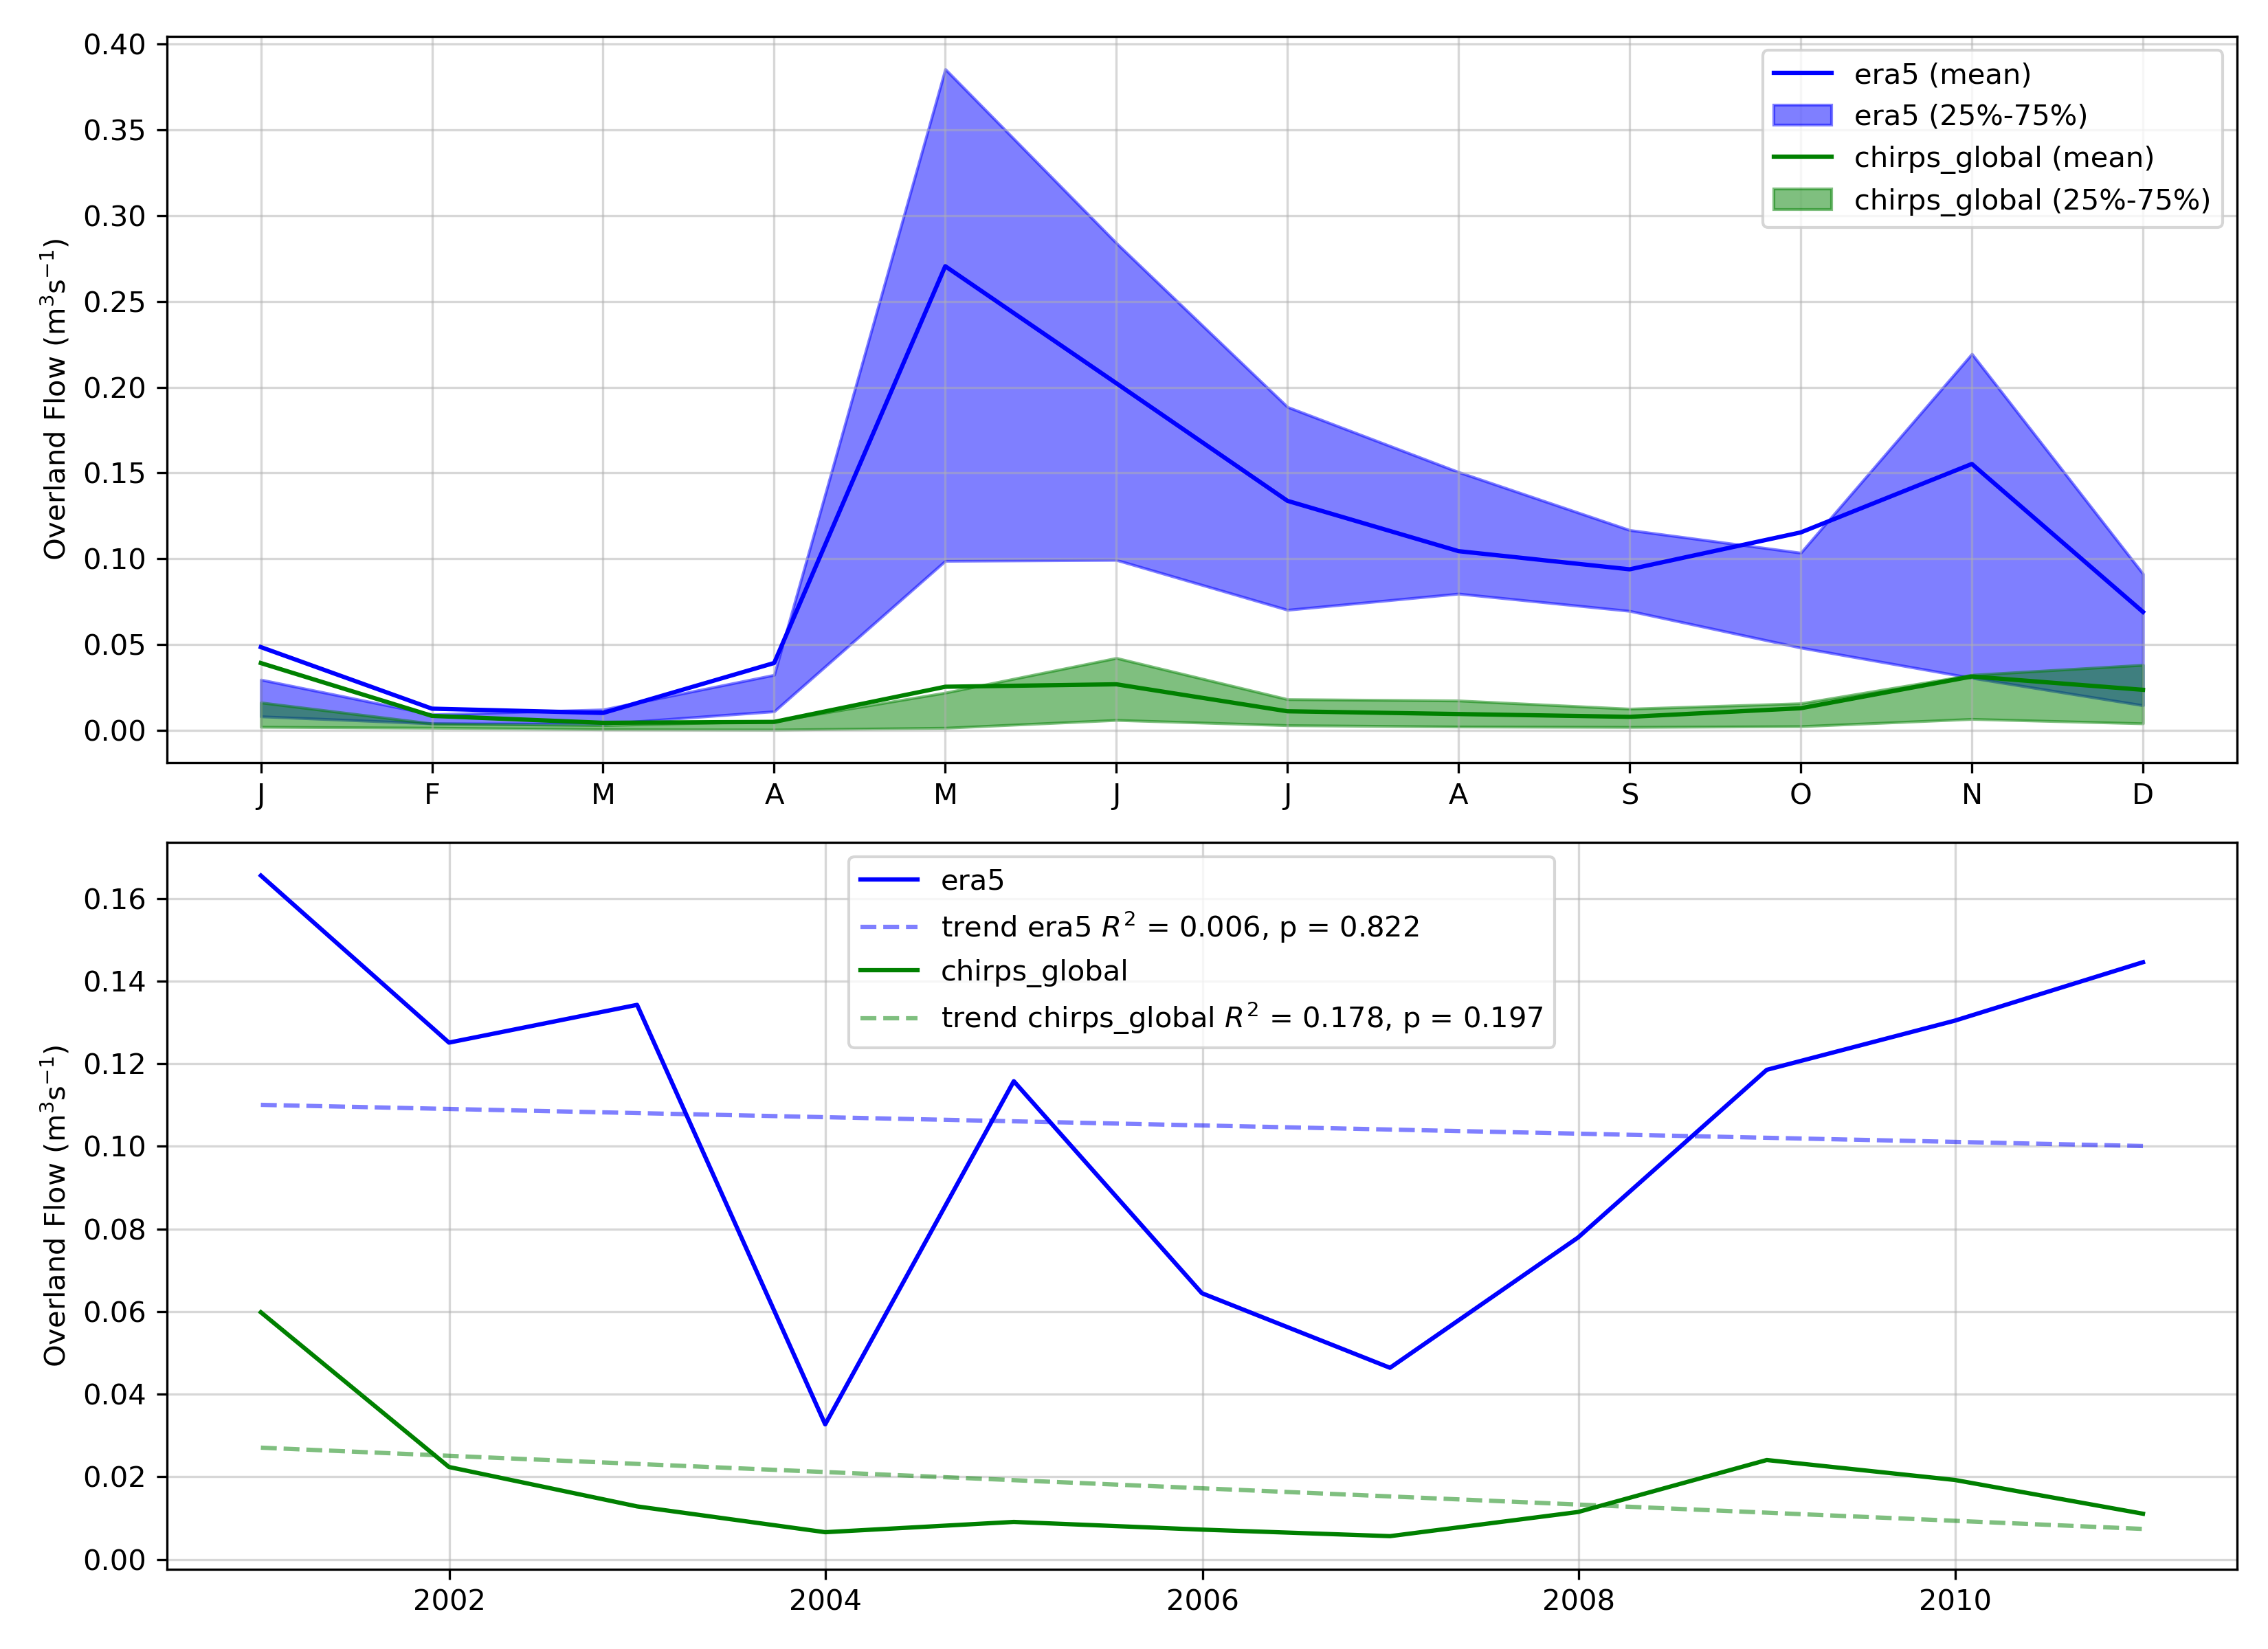

In [20]:
display.Image("./examples/myModel/plots/wflow_model_performance/overland flow_basavg.png")

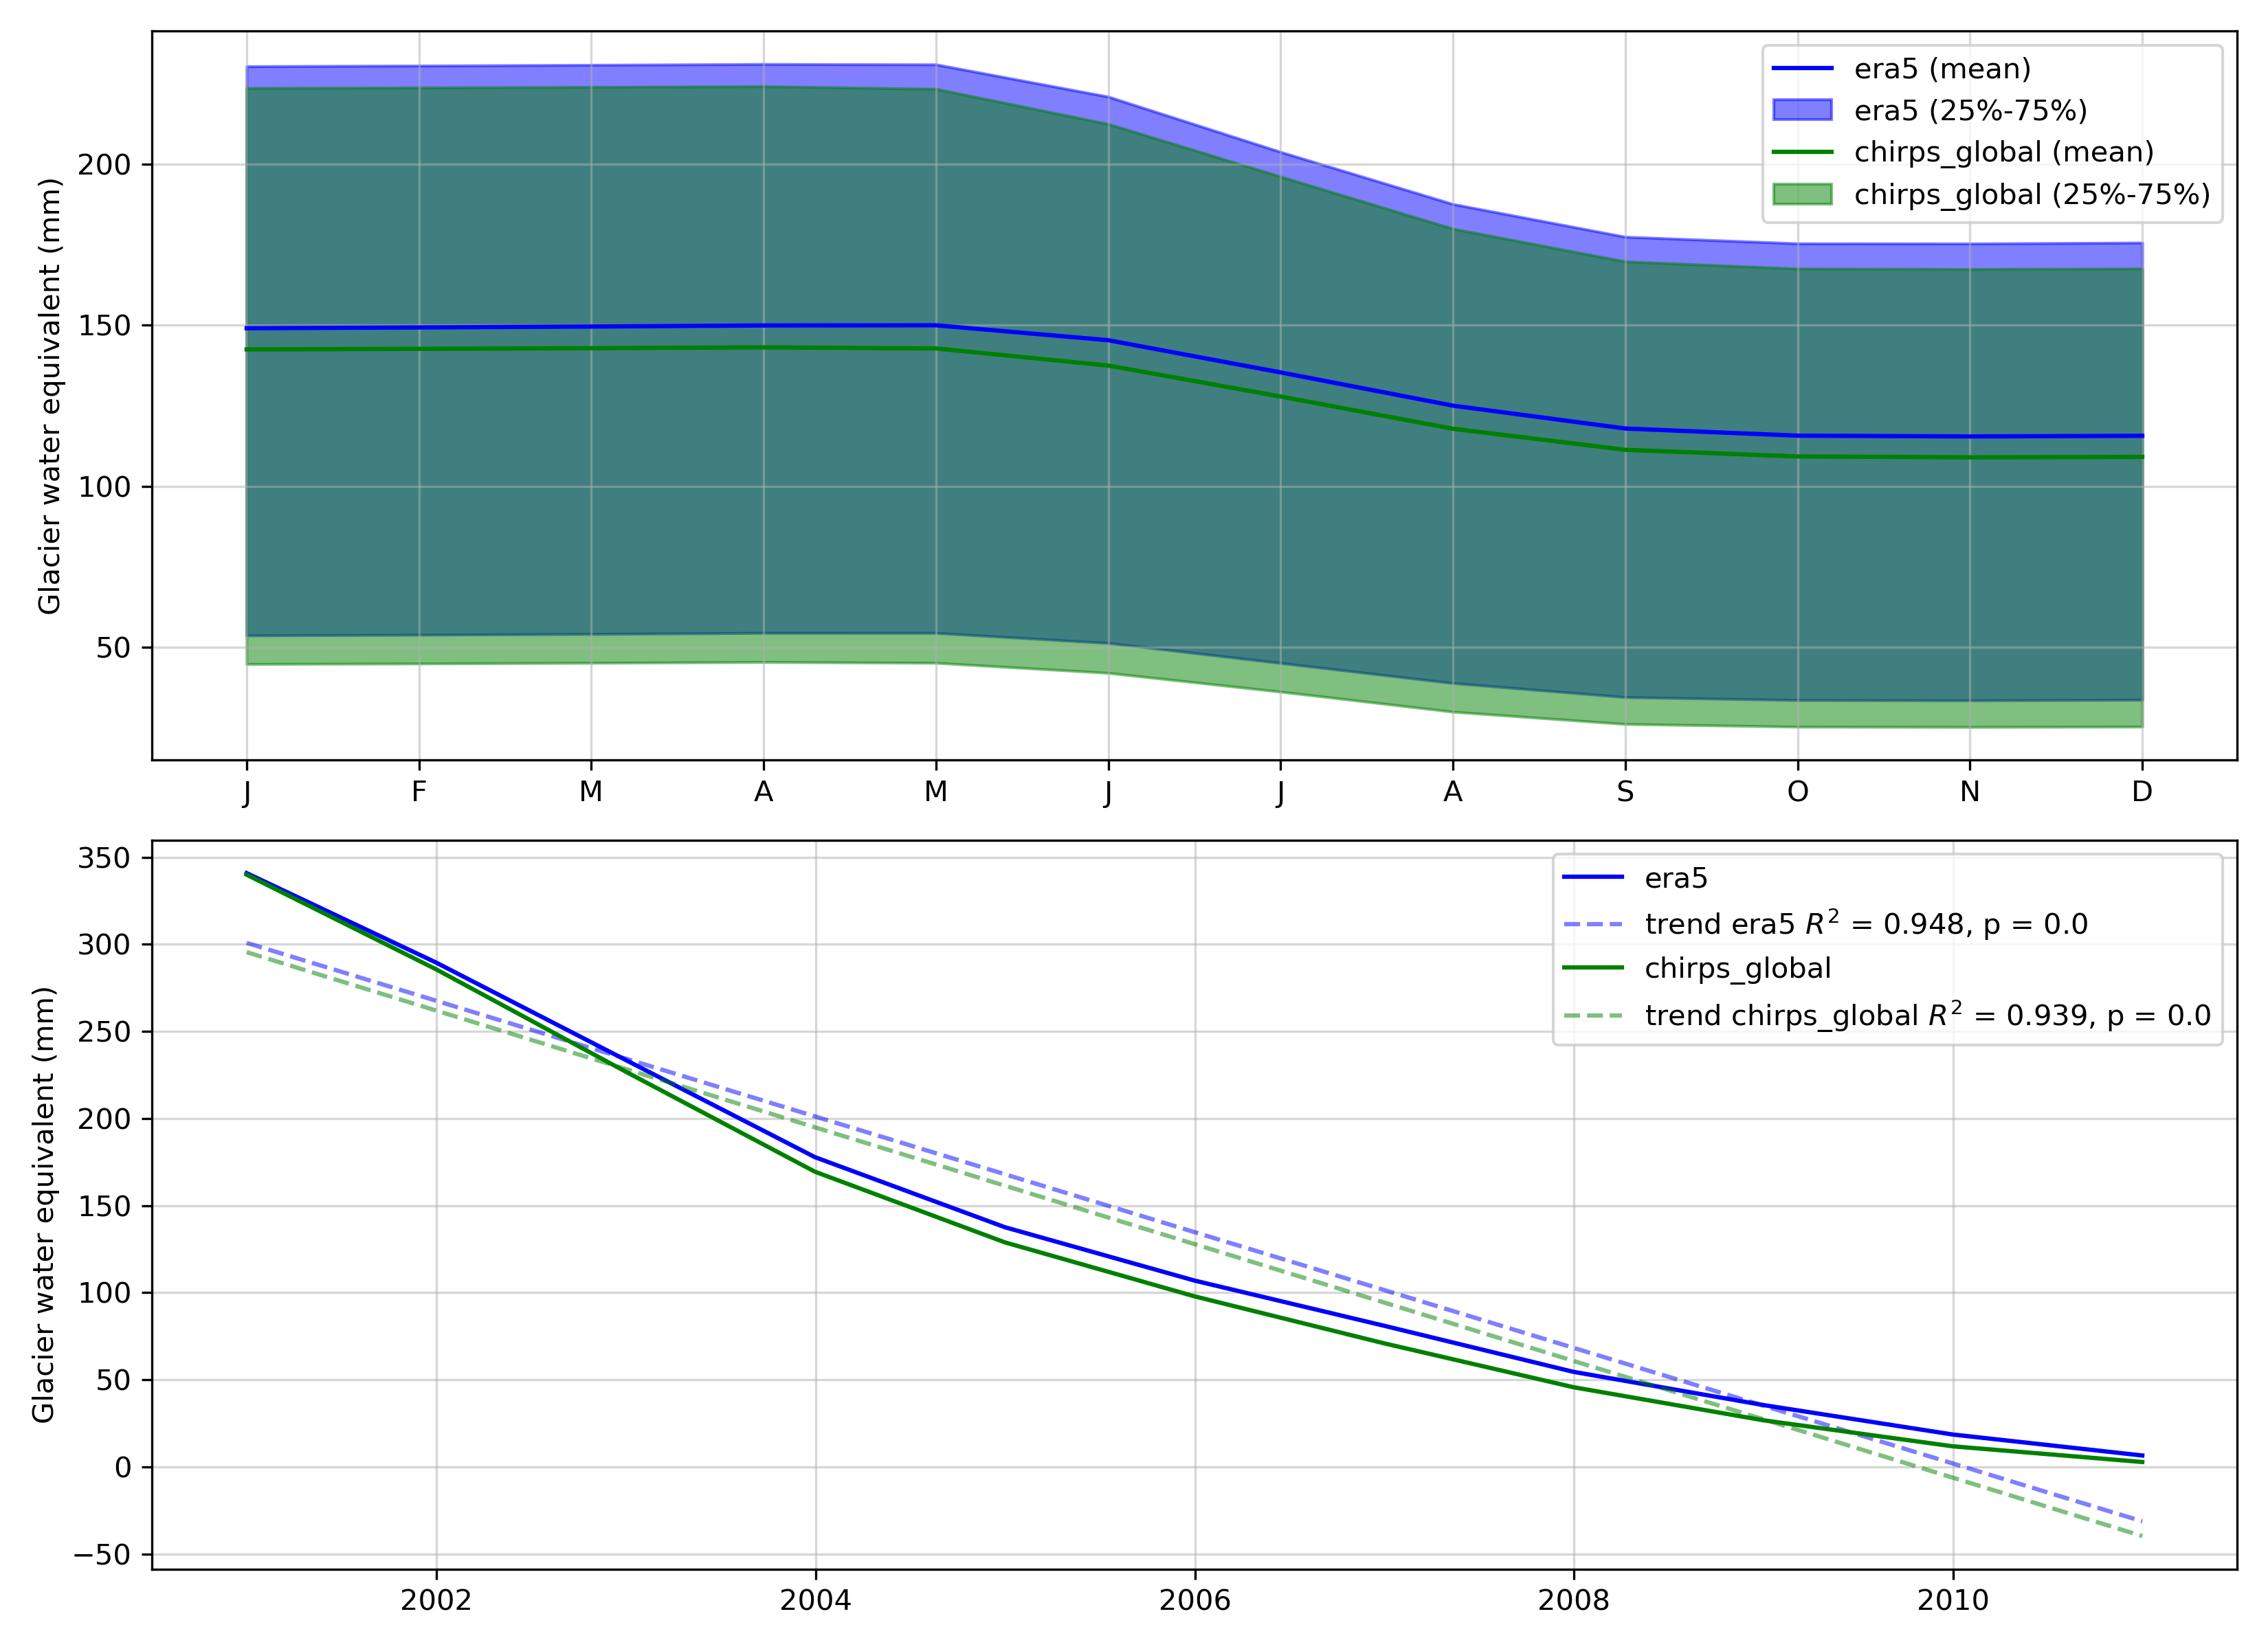

In [21]:
display.Image("./examples/myModel/plots/wflow_model_performance/glacier_basavg.png")

To better understand the observed trends in the simulated (internal) flux and state variables, we also plot trends in the forcing data and the streamflow data.

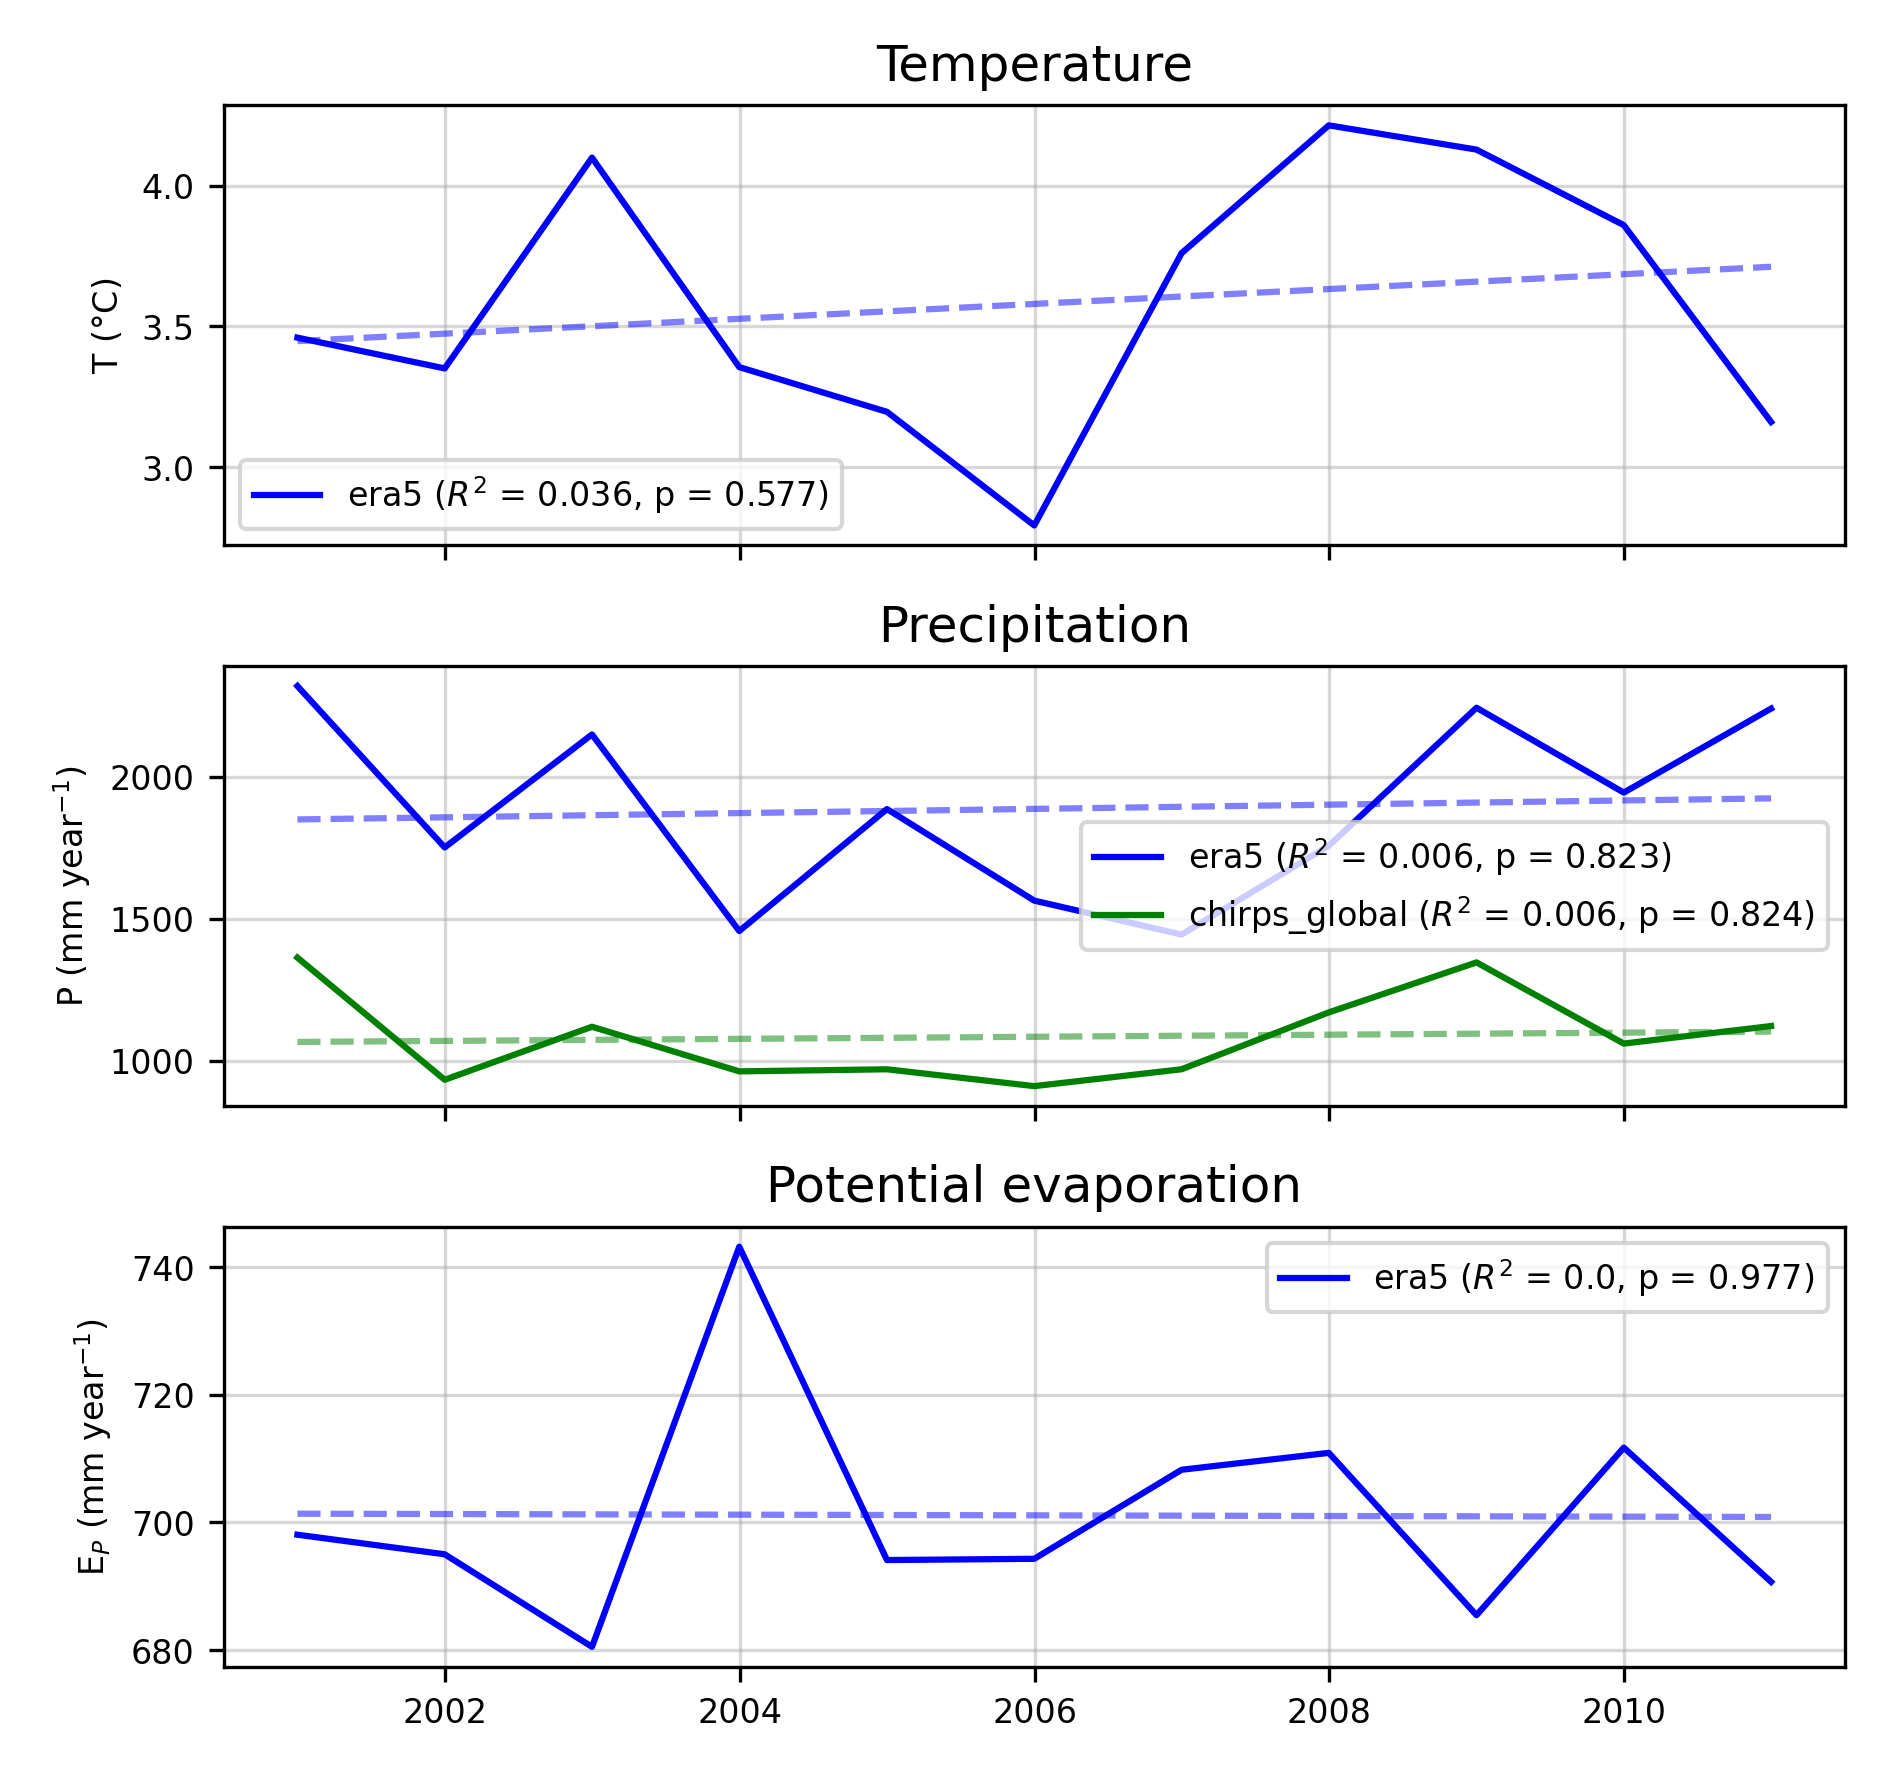

In [22]:
display.Image("./examples/myModel/plots/wflow_model_performance/clim_wflow_1_year.png")

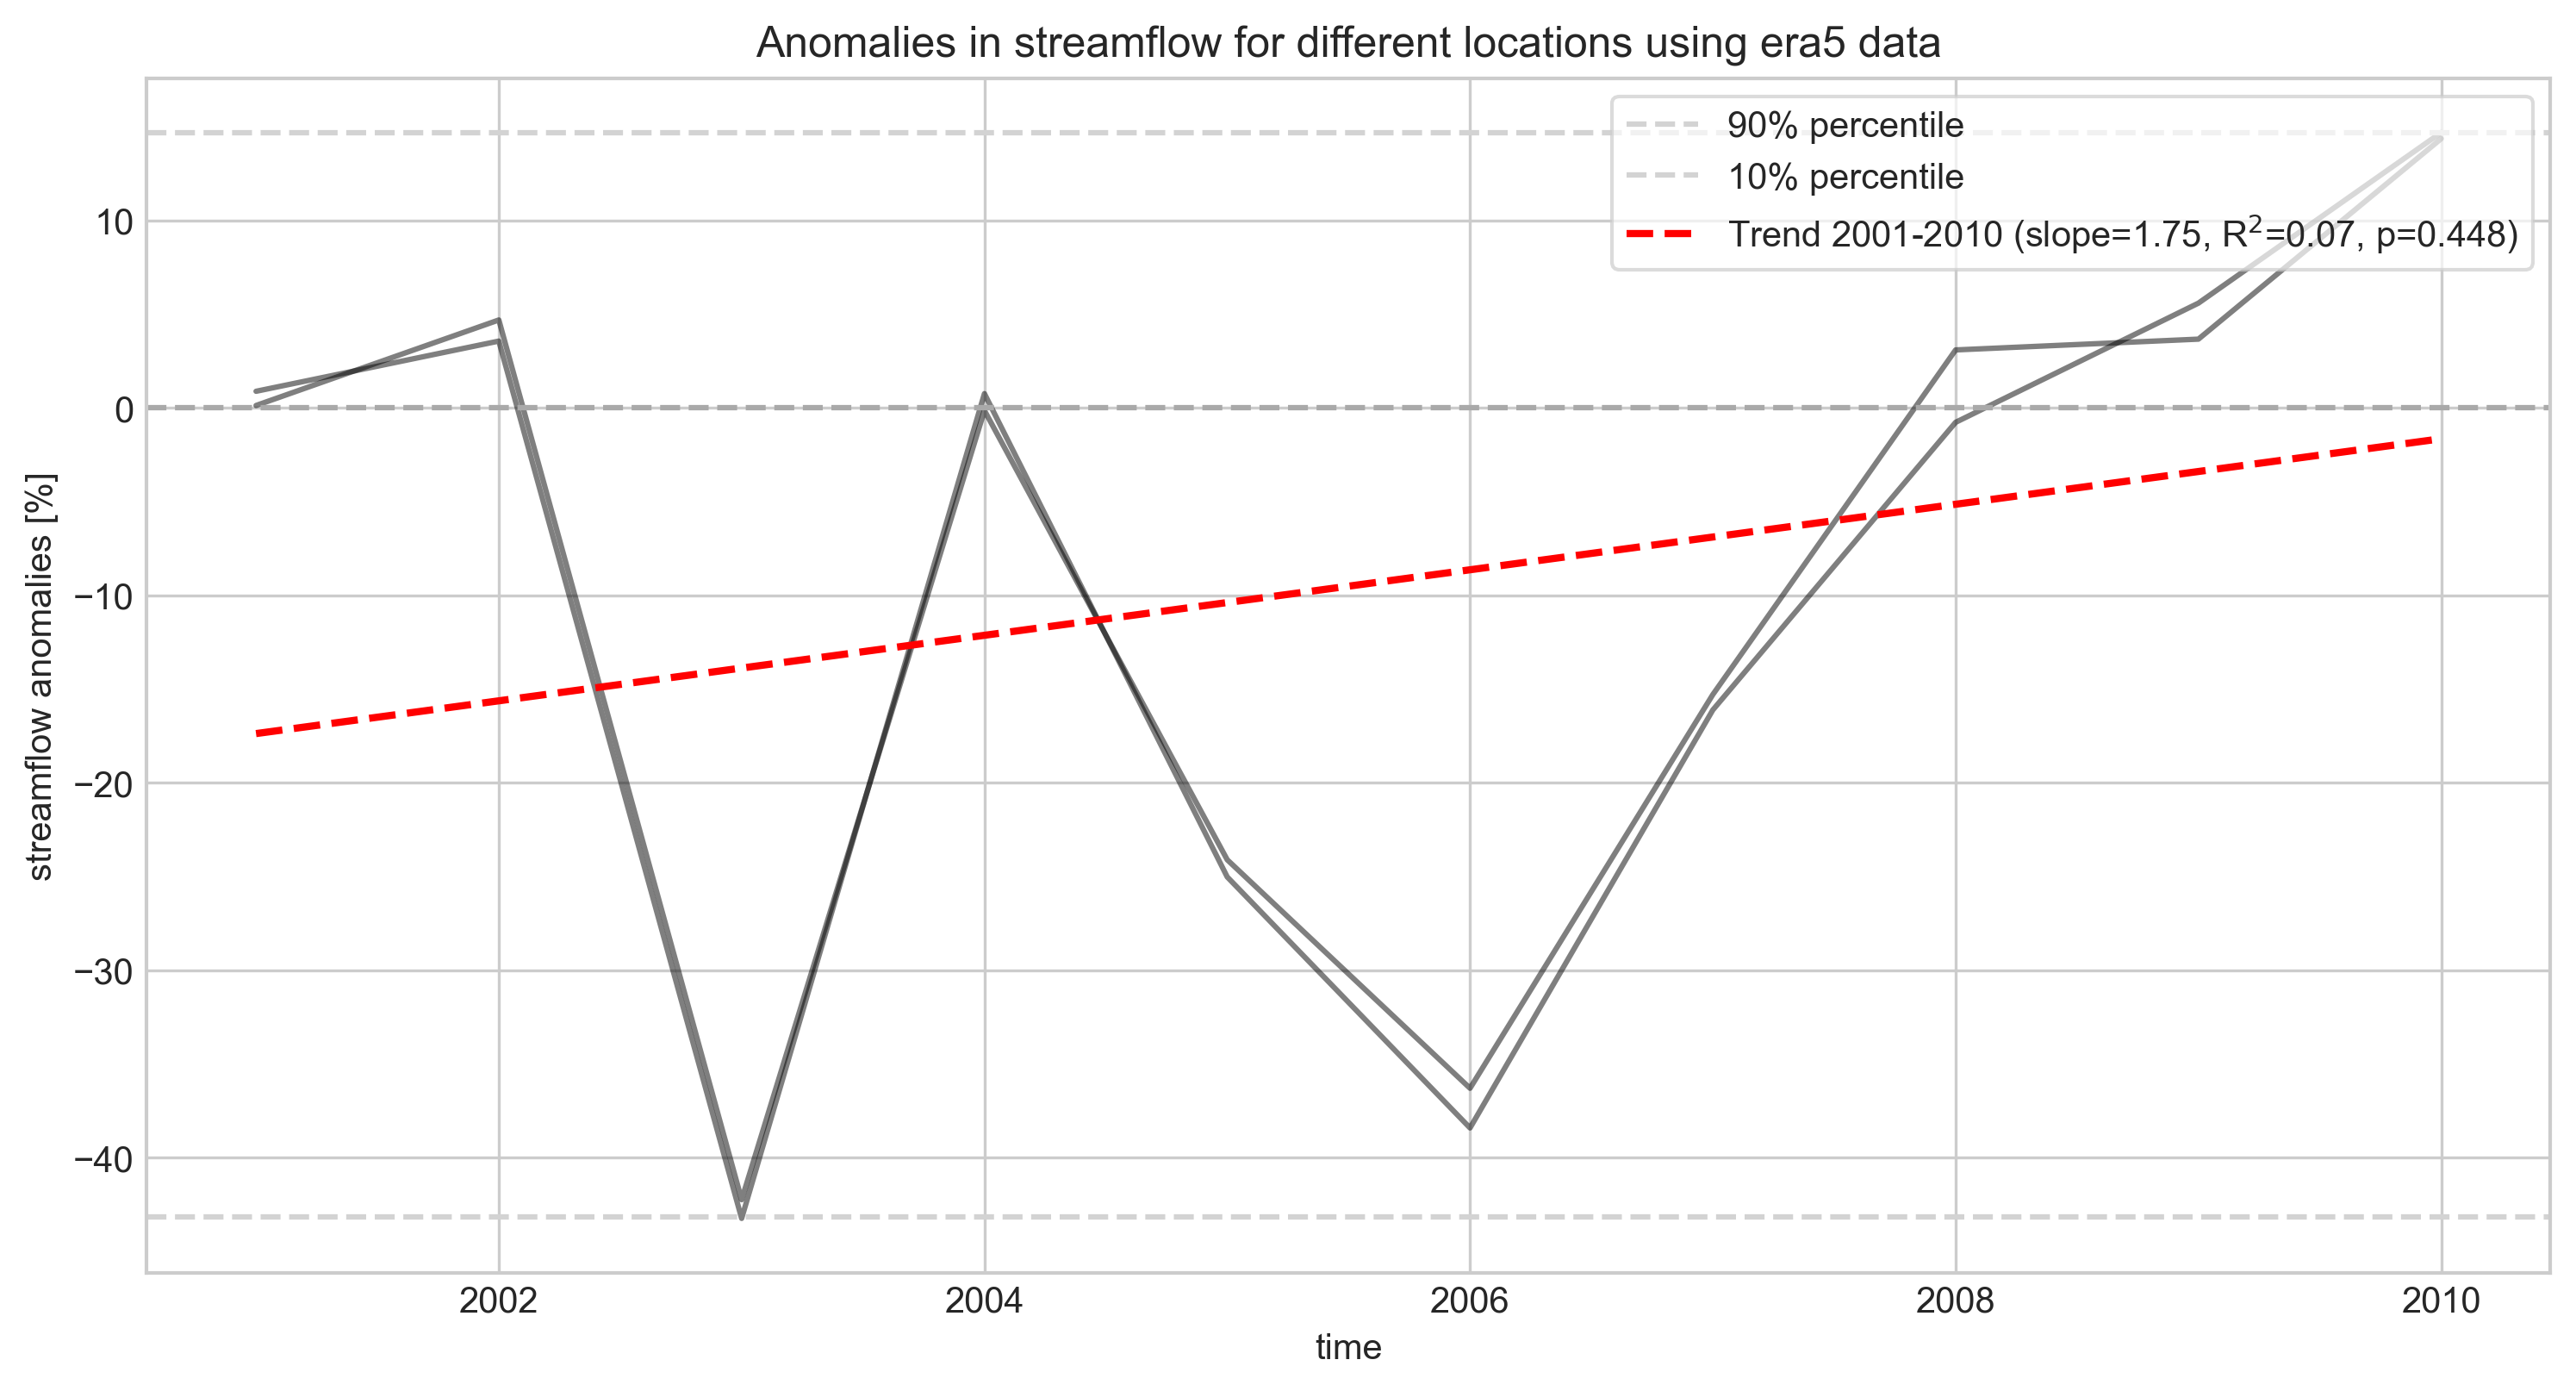

In [23]:
display.Image("./examples/myModel/plots/wflow_model_performance/timeseries_anomalies_Q_era5.png")

The model is also evaluated in its ability to reproduce the snow cover, which is compared to satellite observed snow cover area (in this case from MODIS obervations). 

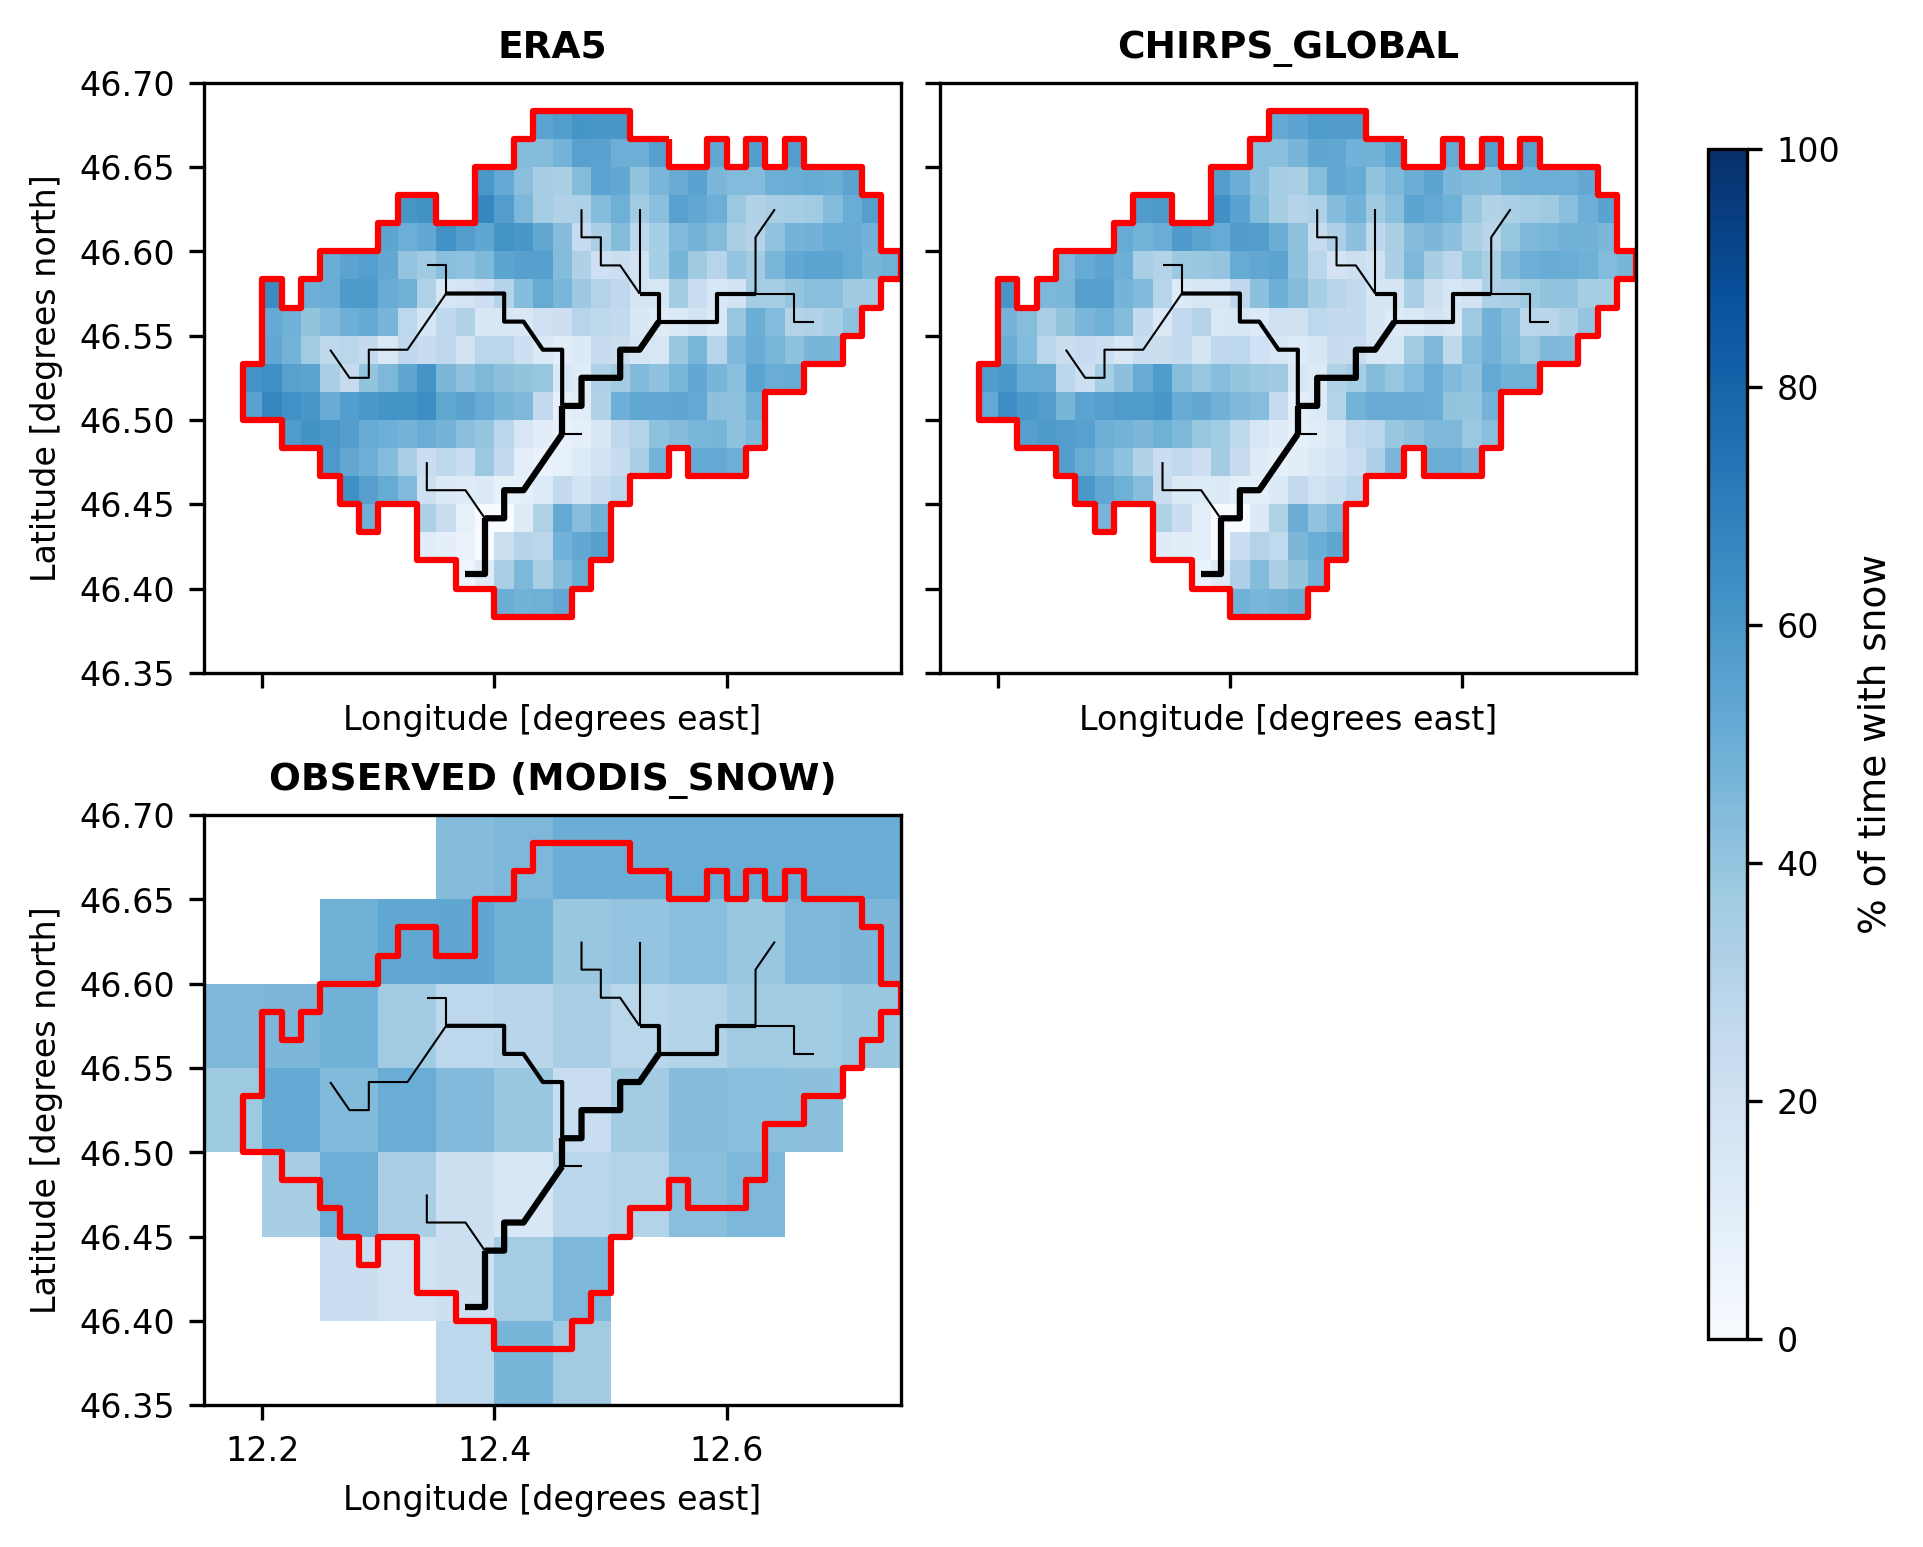

In [24]:
display.Image("./examples/myModel/plots/wflow_model_performance/snow_cover.png") 

The above figures help the user to better understand the behavior of the model. In addition, this analysis provides the user with additional information to select a suitable meteorological dataset for the historical period. As there are large uncertainties in global dataset, precipitation and temperature patterns may be better represented in a dataset compared to another for a specific region. Using observed streamflow data, we are able to make a more informed decision on a more suitable dataset. 

The two-dimensional representation of the runoff ratio (Qobs/P) as a function of the aridity index (Ep/P), commonly referred to as the Budyko space, provides useful insight in the long-term water balance for each climate dataset. 

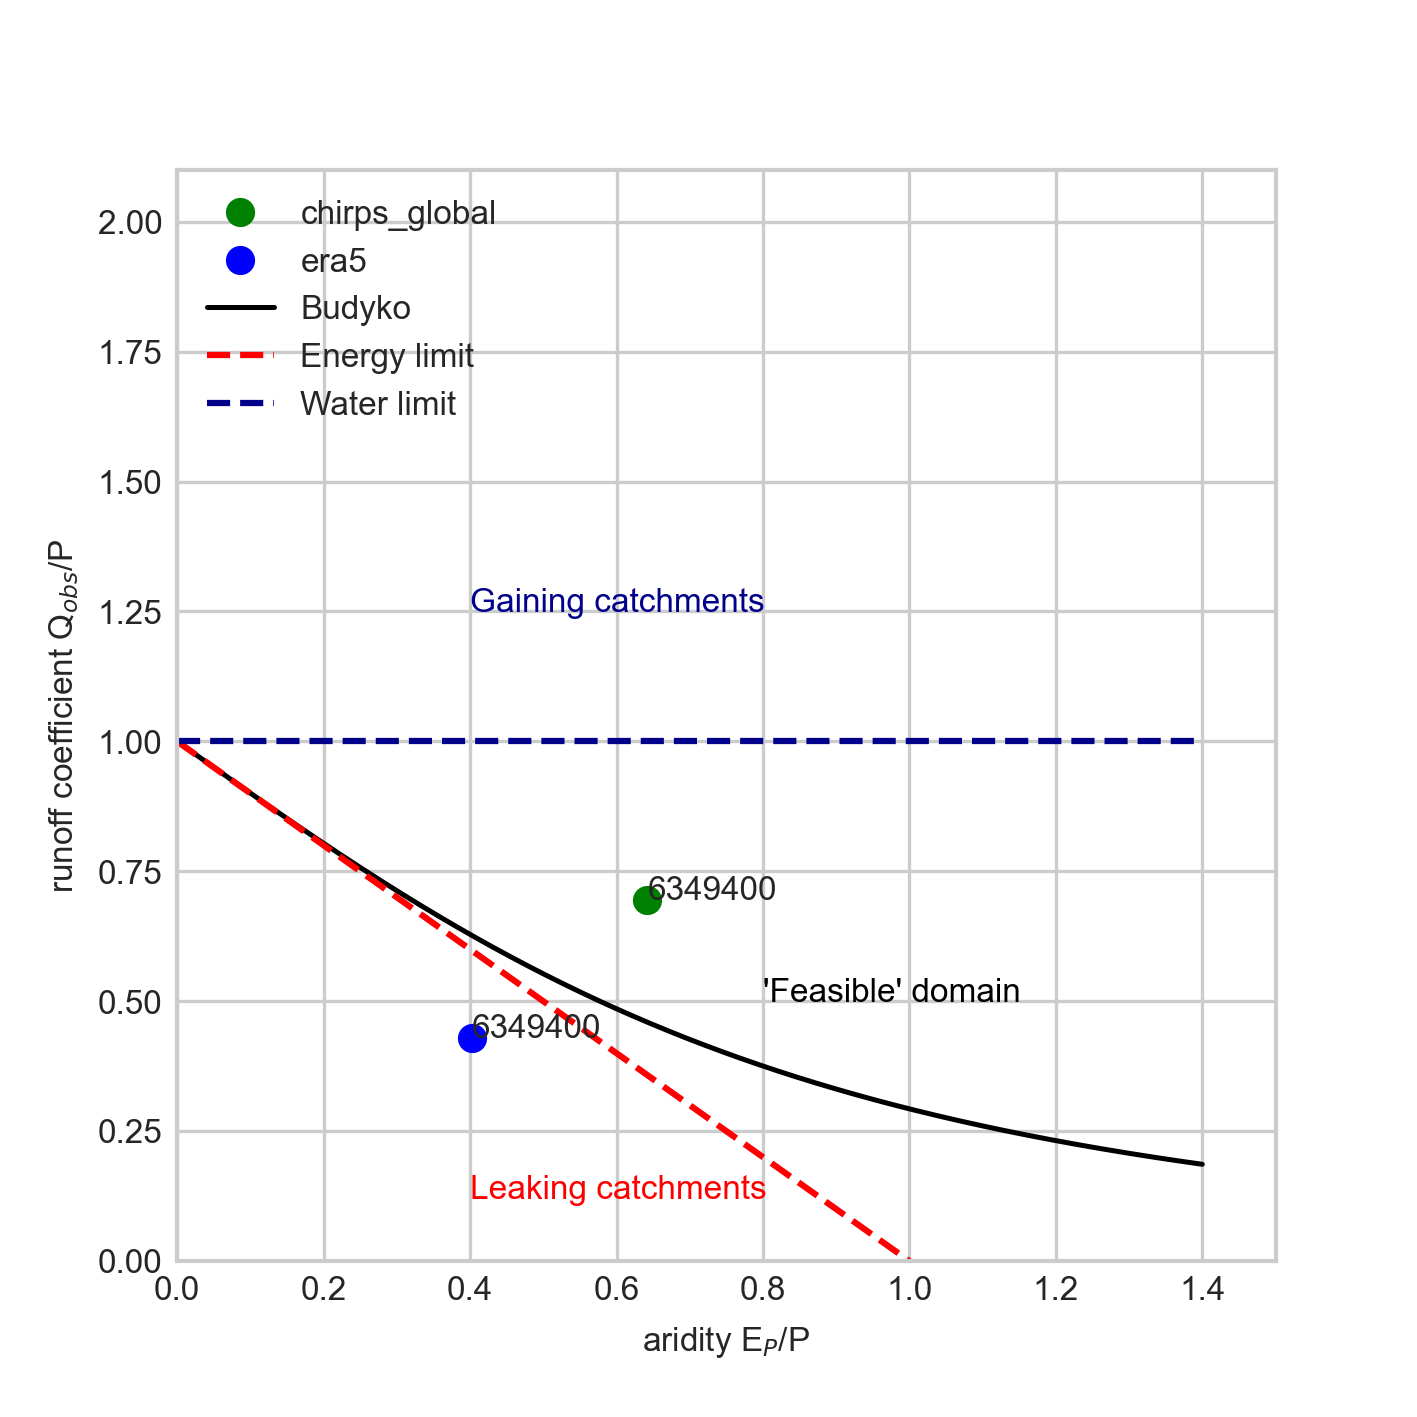

In [25]:
display.Image("./examples/myModel/plots/wflow_model_performance/budyko_qobs.png")

For each catchment where discharge observations are available, we plot the long-term runoff coefficient as a function of the long-term aridity index in the Budyko space for each of the historical meteorological datasets. The Budyko curve is an empirical relation which relates the long-term aridity index to the long-term runoff coefficient based on data of catchments worldwide. The Budyko framework also allows uthe users to visually inspect the balance between water entering the catchment through precipitation and water leaving the catchment as river discharge, i.e. to determine feasible runoff coefficients, given the different precipitation inputs, and observed discharge. If runoff coefficients are larger than 1 using a specific dataset, this could be an indication that precipitation is underestimated. On the other hand, if runoff coefficients are too low given the aridity index, precipitation might be overestimated.  

In the current example, even though ERA5 is not perfect, it still seems to better capture the temporal dynamics of the hydrograph and with some calibration of the hydrological model, we may end up with an acceptable performance!